<a href="https://colab.research.google.com/github/MaximeSzymanski/StocksClusteringVAE/blob/main/VAE_stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf
import pandas as pd
import requests
from bs4 import BeautifulSoup

In [2]:

"""!pip install yfinance
!pip install BeautifulSoup
!pip install requests"""


'!pip install yfinance\n!pip install BeautifulSoup\n!pip install requests'

In [3]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

def download_stocks(ticker_list, start_date='2019-11-08', end_date='2023-11-08'):
    # Set seed for reproducibility
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Initialize an empty list to store normalized values
    normalized_values_list = []
    stocks_kept = []
    iterator = 0
    kept_stocks_with_indexes = []

    # Loop through each stock symbol
    for index, symbol in enumerate(ticker_list):
        try:
            # Download historical stock data using yfinance
            stock_data = yf.download(symbol, start=start_date, end=end_date)

            # Extract the 'Close' column
            close_values = stock_data['Close'].values
            if len(close_values) >= 0:
                # Normalize the data between -1 and 1
                normalized_values = 2 * (close_values - np.min(close_values)) / np.ptp(close_values) - 1
                normalized_values_list.append(normalized_values)
                stocks_kept.append(symbol)
                print(f"stocks {iterator}/{len(ticker_list)}")
                iterator += 1
                kept_stocks_with_indexes.append((index, symbol, normalized_values))
            else:
                # remove the stock if it has not enough data
                print(f"stock {symbol} has not enough data")
                continue
        except Exception as e:
            print(f"Error downloading data for {symbol}: {e}")
            continue

    # get the different lengths of the stocks
    lengths = [len(stock[2]) for stock in kept_stocks_with_indexes]
    lengths_set = set(lengths)

    # get the most common length
    most_common_length = max(set(lengths), key=lengths.count)

    # keep only the stocks with the most common length
    normalized_values_list = [stock[2] for stock in kept_stocks_with_indexes if len(stock[2]) == most_common_length]
    kept_stocks_with_indexes = [(index, symbol) for index, symbol, normalized_values in kept_stocks_with_indexes if len(normalized_values) == most_common_length]

    # length is 1006, so we need to remove the last 6 values for each stock
    normalized_values_list = [normalized_values[:-6] for normalized_values in normalized_values_list]

    return normalized_values_list, kept_stocks_with_indexes

In [4]:
df = pd.DataFrame()
# request this url https://en.wikipedia.org/wiki/List_of_S%26P_600_companies
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_600_companies'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
# get the table by the id constituents
table = soup.find('table', {'id': 'constituents'})
ticker_list = []
# iterate over the tr balise in the table
for tr in table.find_all('tr'):
    # get the first td balise in the tr balise
    td = tr.findAll('td')
    # if the td balise is not empty
    if td is not None and len(td) > 1:
        # get the first a balise in the td balise

        a = td[0].find('a')
        # if the a balise is not empty
        if a is not None:
            # get the text of the a balise
            ticker = a.text
            # add the ticker to the list
            print(f"ticker : {ticker}")
            ticker_list.append(ticker)

ticker : AAON
ticker : AAP
ticker : AAT
ticker : ABCB
ticker : ABG
ticker : ABM
ticker : ABR
ticker : ACA
ticker : ACIW
ticker : ACLS
ticker : ADEA
ticker : ADTN
ticker : ADUS
ticker : AEIS
ticker : AEL
ticker : AEO
ticker : AGO
ticker : AGTI
ticker : AGYS
ticker : AHCO
ticker : AHH
ticker : AIN
ticker : AIR
ticker : AIT
ticker : AKR
ticker : ALEX
ticker : ALG
ticker : ALGT
ticker : ALRM
ticker : AMBC
ticker : AMCX
ticker : AMEH
ticker : AMN
ticker : AMPH
ticker : AMR
ticker : AMSF
ticker : AMWD
ticker : ANDE
ticker : ANF
ticker : ANIP
ticker : AORT
ticker : AOSL
ticker : APAM
ticker : APLE
ticker : APOG
ticker : APPS
ticker : ARCB
ticker : ARI
ticker : ARLO
ticker : AROC
ticker : ARR
ticker : ASIX
ticker : ASO
ticker : ASTE
ticker : ATEN
ticker : ATGE
ticker : ATI
ticker : ATNI
ticker : AUB
ticker : AVA
ticker : AVAV
ticker : AVNS
ticker : AWR
ticker : AX
ticker : AXL
ticker : AZZ
ticker : B
ticker : BANC
ticker : BANF
ticker : BANR
ticker : BCC
ticker : BCPC
ticker : BDN
ticker : BFH

In [5]:
import os
import pickle

percent_of_stocks_to_keep = 0.2
number_of_stocks_to_keep = int(len(ticker_list) * percent_of_stocks_to_keep)
ticker_list =  ticker_list[:number_of_stocks_to_keep]
# Check if the file exists
if os.path.exists('stocks_data.pkl'):
    # If the file exists, load it
    with open('stocks_data.pkl', 'rb') as f:
        stocks_data = pickle.load(f)
else:
    # If the file doesn't exist, download the stocks data
    # This is a placeholder for the code to download the stocks data
    # Replace it with the actual code to download the data
    stocks_data = download_stocks(ticker_list)

    # Save the downloaded data into a file
    with open('stocks_data.pkl', 'wb') as f:
        pickle.dump(stocks_data, f)

kept_stocks_with_indexes = stocks_data[1]
normalized_values_list = stocks_data[0]
print(f"kept_stocks_with_indexes : {kept_stocks_with_indexes}")

'''print(f"number_of_stocks_to_keep : {number_of_stocks_to_keep}")
kept_stocks_with_indexes = kept_stocks_with_indexes[:number_of_stocks_to_keep]
normalized_values_list = normalized_values_list[:number_of_stocks_to_keep]'''

[*********************100%%**********************]  1 of 1 completed
stocks 0/120
[*********************100%%**********************]  1 of 1 completed
stocks 1/120
[*********************100%%**********************]  1 of 1 completed
stocks 2/120
[*********************100%%**********************]  1 of 1 completed
stocks 3/120
[*********************100%%**********************]  1 of 1 completed
stocks 4/120
[*********************100%%**********************]  1 of 1 completed
stocks 5/120
[*********************100%%**********************]  1 of 1 completed
stocks 6/120
[*********************100%%**********************]  1 of 1 completed
stocks 7/120
[*********************100%%**********************]  1 of 1 completed
stocks 8/120
[*********************100%%**********************]  1 of 1 completed
stocks 9/120
[*********************100%%**********************]  1 of 1 completed
stocks 10/120
[*********************100%%**********************]  1 of 1 completed
stocks 11/120
[*************

'print(f"number_of_stocks_to_keep : {number_of_stocks_to_keep}")\nkept_stocks_with_indexes = kept_stocks_with_indexes[:number_of_stocks_to_keep]\nnormalized_values_list = normalized_values_list[:number_of_stocks_to_keep]'

(115, 1000)
donnees x shape : (600, 115, 400)
donnees y shape : (600, 115)
92
(600, 92, 400)
(600, 23, 400)
donnees shape : (115, 1000)
donnes_train shape : (92, 1000)
donnes_test shape : (23, 1000)
train_x : (600, 92, 400)
train_y : (600, 92)
test_x : (600, 23, 400)
test_y : (600, 23)


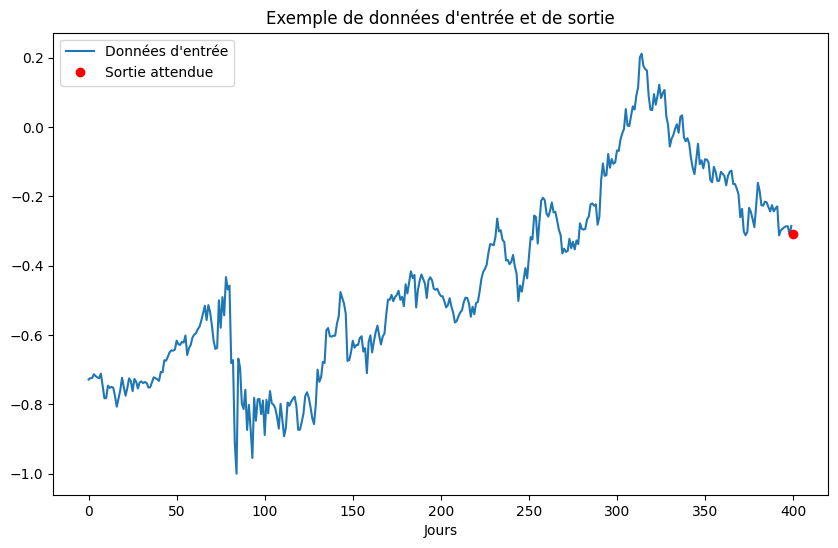

In [115]:
import numpy as np
import matplotlib.pyplot as plt

# Créer un jeu de données fictif pour démonstration

donnees = np.array(normalized_values_list)
print(donnees.shape)
# Fonction pour préparer le dataset
def preparer_dataset(data, longueur_sequence):
    sequences_x = []
    sequences_y = []

    for i in range(len(data[0]) - longueur_sequence):
        sequence_x = data[:, i:i+longueur_sequence]
        sequence_y = data[:, i+longueur_sequence]
        sequences_x.append(sequence_x)
        sequences_y.append(sequence_y)

    return np.array(sequences_x), np.array(sequences_y)

# Définir la longueur de la séquence pour l'entrée du réseau de neurones
longueur_sequence = 400

# Préparer le dataset avec la fonction définie
donnees_x, donnees_y = preparer_dataset(donnees, longueur_sequence)
print(f"donnees x shape : {donnees_x.shape}")
print(f"donnees y shape : {donnees_y.shape}")
stocks_train = int(0.8 * (donnees_x.shape[1]))

train_x, test_x = np.split(donnees_x, [stocks_train], axis=1)

train_y, test_y = np.split(donnees_y, [stocks_train], axis=1)

# Diviser les données en ensembles d'entraînement et de test
print(stocks_train)
print(train_x.shape)
print(test_x.shape)

donnes_train = donnees[:][:stocks_train]
donnes_test = donnees[:][stocks_train:]
print(f"donnees shape : {donnees.shape}")
print(f"donnes_train shape : {donnes_train.shape}")
print(f"donnes_test shape : {donnes_test.shape}")

# Plot des données d'entrée et de sortie
indice_stock = 0  # Indice du stock à visualiser
print(f"train_x : {train_x.shape}")
print(f"train_y : {train_y.shape}")
print(f"test_x : {test_x.shape}")
print(f"test_y : {test_y.shape}")
plt.figure(figsize=(10, 6))
plt.plot(range(longueur_sequence), train_x[0][indice_stock], label='Données d\'entrée')
plt.plot(longueur_sequence, train_y[0][indice_stock], 'ro', label='Sortie attendue')
plt.title('Exemple de données d\'entrée et de sortie')
plt.xlabel('Jours')
plt.legend()
plt.show()


In [116]:
import torch
from torch.utils.data import Dataset, DataLoader

class StockDataset(Dataset):
    def __init__(self, data_x, data_y):
        self.data_x = torch.tensor(data_x, dtype=torch.float32)
        self.data_y = torch.tensor(data_y, dtype=torch.float32)

    def __len__(self):
        return len(self.data_x)

    def __getitem__(self, idx):

        return self.data_x[idx], self.data_y[idx]

# Convertir les données en dataset PyTorch
print(f"train_x : {train_x.shape}")
print(f"train_y : {test_x.shape}")
# flatten the two first dimensions
train_x_non_reshaped = train_x
train_y_non_reshaped = train_y
test_x_non_reshaped = test_x
test_y_non_reshaped = test_y

train_x = train_x.reshape((train_x.shape[0]*train_x.shape[1],train_x.shape[2]))
train_y = train_y.reshape(train_y.shape[0]*train_y.shape[1])
test_x = test_x.reshape((test_x.shape[0]*test_x.shape[1],test_x.shape[2]))
test_y = test_y.reshape(test_y.shape[0]*test_y.shape[1])
print(f"train_x : {train_x.shape}")
print(f"train_y : {train_y.shape}")
print(f"test_x : {test_x.shape}")
print(f"test_y : {test_y.shape}")
train_dataset = StockDataset(train_x, train_y)
test_dataset = StockDataset(test_x, test_y)

# Créer des DataLoadersà
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


train_x : (600, 92, 400)
train_y : (600, 23, 400)
train_x : (55200, 400)
train_y : (55200,)
test_x : (13800, 400)
test_y : (13800,)


In [117]:
for input,output in train_loader:
    # Process each batch
    print("Batch shape:", input.shape, output.shape)  # Adjust this according to your processing needs
    # Your processing logic here
    break

Batch shape: torch.Size([64, 400]) torch.Size([64])


In [118]:
import torch
from torch.utils.data import Dataset, DataLoader

class StockDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Use the previously prepared data
sub_series_length = 400
stock_symbols = [stock[1] for stock in kept_stocks_with_indexes]

# Check that the length of each normalized series is divisible by sub_series_length
number_of_sub_series = len(normalized_values_list[0]) // sub_series_length
print()
for i in range(len(stock_symbols)):
    assert len(normalized_values_list[i]) % sub_series_length == 0

# Create sub-series for each stock
sub_series_list = [normalized_values.reshape((-1, sub_series_length)) for normalized_values in normalized_values_list]

# Convert the list to a numpy array
stocks_np_array = np.zeros((len(stock_symbols), sub_series_list[0].shape[0], sub_series_list[0].shape[1]))
for i in range(len(stock_symbols)):
    stocks_np_array[i] = sub_series_list[i]

# Create a PyTorch Dataset
stock_dataset = StockDataset(stocks_np_array)

# Create a PyTorch DataLoader
batch_size = 32
shuffle = True  # To shuffle the data
data_loader = DataLoader(stock_dataset, batch_size=batch_size, shuffle=shuffle)

# Iterate through the DataLoader to get shuffled batches
for batch in data_loader:
    # Process each batch
    print("Batch shape:", batch.shape)  # Adjust this according to your processing needs
    # Your processing logic here


AssertionError: ignored

In [ ]:
"""# plot the first stock in the train set
plt.figure(figsize=(10, 6))
plt.plot(X_train[0].cpu().detach().numpy(), label='Original signal')
plt.plot(y_train[0:100].cpu().detach().numpy(), label='Reconstructed signal')

plt.legend()
plt.show()
"""

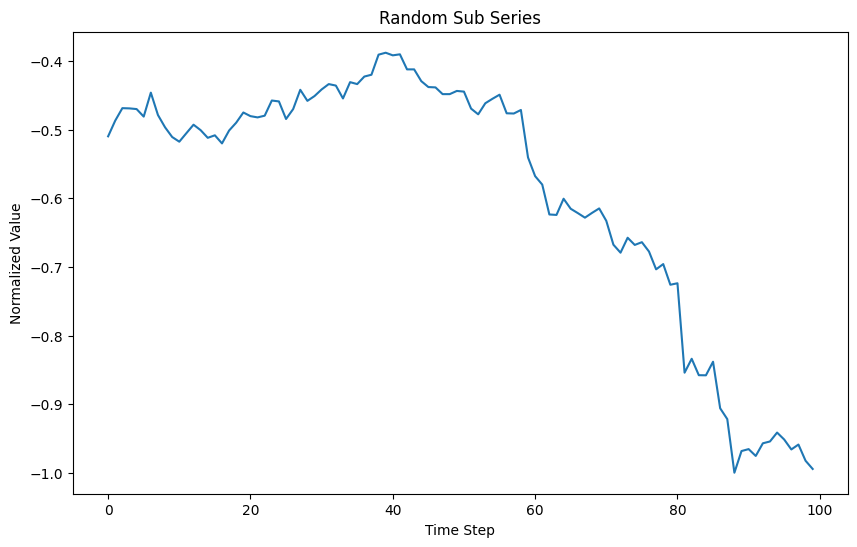

In [119]:
# print a random sub series
number_of_stocks = len(stock_symbols)
random_index_stocks = np.random.randint(0, number_of_stocks)
random_index_sub_series = np.random.randint(0, number_of_sub_series)
plt.figure(figsize=(10, 6))
plt.plot(stocks_np_array[random_index_stocks][random_index_sub_series])
plt.title('Random Sub Series')
plt.xlabel('Time Step')
plt.ylabel('Normalized Value')
plt.show()


In [120]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
class SamplingLayerVAE(nn.Module):
  def __init__(self):
    super(SamplingLayerVAE, self).__init__()

  def forward(self, mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return mu + eps * std

class Encoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64,num_layers=3,bidirectional=False,
               transfromer_hidden_size_attention = 128,num_heads=8,sub_seq_len=20,
               latent_dim=64):
    super(Encoder, self).__init__()
    assert seq_len % sub_seq_len  == 0
    self.number_of_sub_seq = seq_len // sub_seq_len
    self.sub_seq_len = sub_seq_len
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
    self.num_layers = num_layers
    self.bidirectional = bidirectional
    self.chunk_index_embedding = ChunkIndexEmbedding(num_chunks=self.seq_len,embedding_dim=embedding_dim)

    self.mu = nn.Linear((self.sub_seq_len//2)*self.embedding_dim,latent_dim)
    self.log_var = nn.Linear((self.sub_seq_len//2)*self.embedding_dim, latent_dim)
    self.sampling_layer = SamplingLayerVAE()
    self.rnn1 = nn.LSTM(
          input_size=embedding_dim,
          hidden_size=embedding_dim,
          num_layers=self.num_layers,
          batch_first=True,
            bidirectional=self.bidirectional
        )


    multiple_bi = 2 if bidirectional else 1


    #self.positional_encoding = PositionalEncoding(embedding_dim)
    self.embedding_layer = nn.Linear(n_features, embedding_dim)
    print(f"numver sub swq {self.number_of_sub_seq}")
    self.transformer_1 = CompressWithAttentionResidual(input_size=self.hidden_dim,output_size=embedding_dim,
                                             hidden_size_attention=embedding_dim*2,
                                             group_size=self.number_of_sub_seq)

    self.transformer_2 = CompressWithAttentionResidual(input_size=embedding_dim,output_size=embedding_dim,
                                             hidden_size_attention=embedding_dim,
                                             group_size=2)


  def forward(self, x):
    batch_size, seq_len, n_features = x.size()
    original_x = x

    #x = x.reshape((batch_size * seq_len, n_features))
    x = self.embedding_layer(x)
    x = F.relu(x)
    x = self.chunk_index_embedding(x)
    x = F.relu(x)
    x, (_, _) = self.rnn1(x)


    x = self.transformer_1(x)
    x = self.transformer_2(x)
    x = x.reshape((batch_size, (self.sub_seq_len//2)*self.embedding_dim))
    mu = self.mu(x)
    log_var = self.log_var(x)
    z = self.sampling_layer(mu, log_var)

    return z, mu, log_var, original_x



class Decoder(nn.Module):
  def __init__(self, seq_len, input_dim=64, n_features=1,num_layers=3,bidirectional=False,
               sub_seq_len=20,latent_dim=64):
    super(Decoder, self).__init__()
    assert seq_len % sub_seq_len  == 0
    self.number_of_sub_seq = seq_len // sub_seq_len
    # number
    self.sub_seq_len = sub_seq_len
    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features
    self.num_layers = num_layers
    self.bidirectional = bidirectional
    self.expend_layer_1 = ExpandWithAttentionResidual(input_size=latent_dim,output_size=input_dim,
                                             hidden_size_attention=latent_dim,
                                             group_size=self.sub_seq_len ,expansion_factor=
                                                    self.number_of_sub_seq)

    self.expend_layer_2 = ExpandWithAttentionResidual(input_size=input_dim,output_size=input_dim,
                                             hidden_size_attention=input_dim,
                                             group_size=self.sub_seq_len*self.number_of_sub_seq,expansion_factor=2)

    self.output_embeding = OutputEmbedding(input_dim=self.hidden_dim,seq_len=self.seq_len,output_dim=1)
    self.chunk_index_embedding = ChunkIndexEmbedding(num_chunks=self.seq_len,embedding_dim=input_dim)
    self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=self.num_layers,
          batch_first=True,
            bidirectional=self.bidirectional
        )

    multiple_bi = 2 if bidirectional else 1

  def forward(self, x):

    batch_size = x.size(0)
    # x is shape (batch_size, 1, n_features)
    # repeat the last dimension to have (batch_size, seq_len, n_features)
    x = x.unsqueeze(1)
    x = x.repeat(1, self.sub_seq_len//2, 1)

    x = self.expend_layer_1(x)
    x = F.relu(x)
    x = self.chunk_index_embedding(x)
    x = F.relu(x)
    x = self.expend_layer_2(x)
    x = F.relu(x)
    x, (hidden_n, cell_n) = self.rnn1(x)
    x = x.reshape((batch_size,self.seq_len, self.hidden_dim))
    x = self.output_embeding(x)

    # keep only the last layer


    return x
class ExpandWithAttentionResidual(nn.Module):
    def __init__(self, input_size, output_size, hidden_size_attention, group_size, expansion_factor):
        super(ExpandWithAttentionResidual, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size_attention
        self.group_size = group_size
        self.expansion_factor = expansion_factor

        # Linear projections for attention
        self.Q_linear = nn.Linear(self.input_size, self.expansion_factor * self.hidden_size)
        self.K_linear = nn.Linear(self.input_size, self.expansion_factor * self.hidden_size)
        self.V_linear = nn.Linear(self.input_size, self.expansion_factor * self.hidden_size)

        # Final linear transformations
        self.attention_output_linear = nn.Linear(self.expansion_factor * self.hidden_size,  self.expansion_factor * self.hidden_size)
        self.output_linear = nn.Linear(self.hidden_size , self.output_size)
        self.norma = nn.LayerNorm(self.hidden_size)
    def forward(self, x):
        # x is shape (batch_size, seq_len, n_features)
        batch_size, seq_len, n_features = x.size()
        # Use attention to expand the input

        x = x.view(batch_size* seq_len , n_features)
        Q = self.Q_linear(x)
        K = self.K_linear(x)
        V = self.V_linear(x)
        Q = Q.reshape((batch_size, seq_len, self.expansion_factor * self.hidden_size))
        K = K.reshape((batch_size, seq_len, self.expansion_factor * self.hidden_size))
        V = V.reshape((batch_size, seq_len, self.expansion_factor * self.hidden_size))
        # Compute attention weights
        attention_weights = torch.matmul(Q, K.transpose(-2, -1)) / (self.hidden_size ** 0.5)
        attention_weights = F.softmax(attention_weights, dim=-1)

        # Apply attention weights to values
        attended_values = torch.matmul(attention_weights, V)

        # Apply final linear transformations
        attended_values = attended_values.reshape((batch_size* seq_len , self.expansion_factor * self.hidden_size))
        attention_output = self.attention_output_linear(attended_values)

        # Reshape attention output into groups of size self.group_size
        attention_output = attention_output.view(batch_size, seq_len* self.expansion_factor ,self.hidden_size)

        # Add residual connection
        # repeat the tensor x to have the same shape as attention_output
        # repeat to have from (batch_size, seq_len, n_features) to (batch_size, seq_len* self.expansion_factor ,n_features)
        x = x.view(batch_size, seq_len, n_features)
        x = x.repeat(1, self.expansion_factor, 1)
        out = attention_output + x
        batch_size, expended_seq_len, n_features = out.size()
        # normalize the output
        out = out.reshape((batch_size* expended_seq_len , n_features))
        #out = self.norma(out)

        # Final linear transformation
        out = self.output_linear(out)

        # RElu
        out = F.relu(out)
        out = out.reshape((batch_size, expended_seq_len, self.output_size))
        return out

class CompressWithAttentionResidual(nn.Module):
    def __init__(self, input_size, output_size, hidden_size_attention, group_size):
        super(CompressWithAttentionResidual, self).__init__()
        self.input_size = input_size
        print(f"ouput size : {output_size}")
        self.output_size = output_size
        self.hidden_size = hidden_size_attention
        self.group_size = group_size

        # Linear projections for attention
        self.Q_linear = nn.Linear(self.input_size, self.hidden_size)
        self.K_linear = nn.Linear(self.input_size, self.hidden_size)
        self.V_linear = nn.Linear(self.input_size, self.hidden_size)

        # Final linear transformations
        self.attention_output_linear = nn.Linear(self.hidden_size, self.hidden_size)
        self.output_linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x):
        # x is shape (batch_size, seq_len, n_features)
        batch_size, seq_len, n_features = x.size()
        # Reshape input into groups of size self.group_size

        x = x.view(batch_size, -1, self.group_size, n_features)
        group_len = x.size(1)

        # Linear projections for attention
        Q = self.Q_linear(x)
        K = self.K_linear(x)
        V = self.V_linear(x)

        # Compute attention weights
        attention_weights = torch.matmul(Q, K.transpose(-2, -1)) / (self.hidden_size ** 0.5)
        attention_weights = F.softmax(attention_weights, dim=-1)

        # Apply attention weights to values
        attended_values = torch.matmul(attention_weights, V)

        # Sum along the group dimension
        attended_values = attended_values.sum(dim=2)

        # Apply final linear transformations
        attention_output = self.attention_output_linear(attended_values)


        # Add residual connection
        # so, we need to pack the tensor x to have the same shape as attention_output. We have to do : x[i] = x[i] + x[i+1] and so on paired by 2
        group_size = self.group_size
        print(f"group_size : {group_size}")
# Create slices and sum them based on the group size
        slices = [x[:, i::group_size, :] for i in range(group_size)]
        [print(f"slice shape : {slice.shape}") for slice in slices]
        print(f"x shape :  : {x.shape}")
        x = sum(slices)
        # Final linear transformation

        batch_size_2, sub_series_length, n_features = attention_output.size()


        x = x.reshape((batch_size_2 , sub_series_length, n_features))
        out = attention_output + x

        # Final linear transformation
        out = self.output_linear(out)

        # RElu
        out = F.relu(out)
        return out


class ChunkIndexEmbedding(nn.Module):
    def __init__(self,num_chunks=100,embedding_dim=64):
        super(ChunkIndexEmbedding, self).__init__()
        self.num_chunks = num_chunks
        self.embedding = nn.Embedding(self.num_chunks,embedding_dim )

    def forward(self, x):
        batch_size, seq_len, n_features = x.size()
        chunk_index = torch.arange(0, seq_len, 1).to(x.device)

        chunk_index = chunk_index.unsqueeze(0).repeat(batch_size, 1)

        chunk_index = self.embedding(chunk_index)

        x = x + chunk_index
        return x

class InputEmbedding(nn.Module):
    def __init__(self,seq_len, input_dim=1,output_dim=64):
        super(InputEmbedding, self).__init__()

        self.seq_len = seq_len
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embedding = nn.Linear(self.input_dim, self.output_dim)
    def forward(self, x):
        batch_size, seq_len, n_features = x.size()
        x = x.reshape((batch_size * seq_len, n_features))
        x = self.embedding(x)
        x = x.reshape((batch_size, seq_len, self.output_dim))
        return x

class OutputEmbedding(nn.Module):
    def __init__(self,seq_len, input_dim=64,output_dim=1):
        super(OutputEmbedding, self).__init__()

        self.seq_len = seq_len
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embedding = nn.Linear(self.input_dim, self.output_dim)
    def forward(self, x):
        batch_size, seq_len, n_features = x.size()
        x = x.reshape((batch_size * seq_len, n_features))
        x = self.embedding(x)
        x = x.reshape((batch_size, seq_len, self.output_dim))
        return x




In [121]:
class SimpleEncoderLSTM(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64,num_layers=3,bidirectional=False,latent_dim=64):
    super(SimpleEncoderLSTM, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
    print(f"hidden_dim: {self.hidden_dim}")
    self.num_layers = num_layers
    self.bidirectional = bidirectional
    self.chunk_index_embedding = ChunkIndexEmbedding(num_chunks=self.seq_len,embedding_dim=embedding_dim)
    self.embedding_layer = nn.Linear(n_features, embedding_dim)

    self.rnn1 = nn.LSTM(
          input_size=embedding_dim,
          hidden_size=self.hidden_dim,
          num_layers=self.num_layers,
          batch_first=True,
            bidirectional=self.bidirectional
        )


    multiple_bi = 2 if bidirectional else 1

    self.rnn2 = nn.LSTM(
          input_size=multiple_bi * self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=self.num_layers,
          batch_first=True
    )

    self.mu = torch.nn.Linear(self.seq_len * embedding_dim, latent_dim)
    self.log_var = torch.nn.Linear(self.seq_len * embedding_dim, latent_dim)
    self.sampling_layer = SamplingLayerVAE()



  def forward(self, x):
    original_x = x
    batch_size, seq_len, n_features = x.size()
    #x = x.reshape((batch_size * seq_len, n_features))
    x = self.embedding_layer(x)
    x = nn.ReLU()(x)
    x = self.chunk_index_embedding(x)
    x = nn.ReLU()(x)
    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)
    x = x.reshape((batch_size, self.seq_len * self.embedding_dim))
    mu = self.mu(x)
    log_var = self.log_var(x)
    z = self.sampling_layer(mu, log_var)

    return z, mu, log_var,  original_x

class SimpleDecoderLSTM(nn.Module):
  def __init__(self, seq_len, input_dim=64, n_features=1,num_layers=3,bidirectional=False):
    super(SimpleDecoderLSTM, self).__init__()
    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features
    self.num_layers = num_layers
    self.bidirectional = bidirectional
    self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=self.num_layers,
          batch_first=True,
            bidirectional=self.bidirectional
        )

    multiple_bi = 2 if bidirectional else 1
    self.rnn2 = nn.LSTM(
      input_size=input_dim * multiple_bi,
      hidden_size=self.hidden_dim,
      num_layers=self.num_layers,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):


    batch_size = x.size(0)
    # x is shape (batch_size,  n_features)
    # repeat the last dimension to have (batch_size, seq_len, n_features)
    x = x.unsqueeze(1)
    x = x.repeat(1, self.seq_len, 1)

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((batch_size,self.seq_len, self.hidden_dim))
    # keep only the last layer


    return self.output_layer(x)


In [122]:
class PredictNextDayHead(nn.Module):
    def __init__(self,latent_dim,hidden_dim=64):
        super(PredictNextDayHead, self).__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.linear_1 = nn.Linear(self.latent_dim,self.hidden_dim)
        self.linear_2 = nn.Linear(self.hidden_dim,1)

    def forward(self,x):
        x = self.linear_1(x)
        x = nn.ReLU()(x)
        x = self.linear_2(x)
        x = nn.Tanh()(x)
        return x


In [123]:
class RecurrentAutoencoder_LSTM(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64,latent_dim=2):
    super(RecurrentAutoencoder_LSTM, self).__init__()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.encoder = SimpleEncoderLSTM(seq_len, n_features, embedding_dim,bidirectional=True,num_layers=1,latent_dim=latent_dim).to(device)
    self.decoder = SimpleDecoderLSTM(seq_len, latent_dim, n_features,bidirectional=True,num_layers=1).to(device)
  def forward(self, x):
    z, mu, log_var,  original_x = self.encoder(x)

    x = self.decoder(z)
    x = nn.Tanh()(x)
    return x, original_x, mu, log_var

  def predict_next_day(self,x):
        z, mu, log_var, original_x = self.encoder(x)
        x = self.decoder(z)
        return x


In [124]:
latent_dim = 100
sub_series_length = 400
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_LSTM = RecurrentAutoencoder_LSTM(sub_series_length, 1, 32,latent_dim=latent_dim).to(device)
print(f"model : {model_LSTM}")

hidden_dim: 64
model : RecurrentAutoencoder_LSTM(
  (encoder): SimpleEncoderLSTM(
    (chunk_index_embedding): ChunkIndexEmbedding(
      (embedding): Embedding(400, 32)
    )
    (embedding_layer): Linear(in_features=1, out_features=32, bias=True)
    (rnn1): LSTM(32, 64, batch_first=True, bidirectional=True)
    (rnn2): LSTM(128, 32, batch_first=True)
    (mu): Linear(in_features=12800, out_features=100, bias=True)
    (log_var): Linear(in_features=12800, out_features=100, bias=True)
    (sampling_layer): SamplingLayerVAE()
  )
  (decoder): SimpleDecoderLSTM(
    (rnn1): LSTM(100, 100, batch_first=True, bidirectional=True)
    (rnn2): LSTM(200, 200, batch_first=True)
    (output_layer): Linear(in_features=200, out_features=1, bias=True)
  )
)


In [125]:
class RecurrentAutoencoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=128,sub_seq_len=10,latent_dim=2):
    super(RecurrentAutoencoder, self).__init__()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.encoder = Encoder(seq_len, n_features, embedding_dim,bidirectional=True,num_layers=1,
        sub_seq_len=sub_seq_len,latent_dim=latent_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features,bidirectional=True,num_layers=1,
        sub_seq_len=sub_seq_len,latent_dim=latent_dim).to(device)

    self.predict_next_day_head = PredictNextDayHead(latent_dim=latent_dim).to(device)
  def forward(self, x):
    z, mu, sigma, original_x = self.encoder(x)
    x = self.decoder(z)
    x = nn.Tanh()(x)
    return x, original_x, mu, sigma

  def predict_next_day(self,x):
    z, mu, sigma, original_x = self.encoder(x)
    x = self.predict_next_day_head(z)
    return x

In [126]:
print(f"sub_series_length : {300}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 100
model_attention = RecurrentAutoencoder(sub_series_length, 1, 32,sub_seq_len=200,latent_dim=latent_dim).to(device)


sub_series_length : 300
numver sub swq 2
ouput size : 32
ouput size : 32


In [127]:
print(model_attention)

RecurrentAutoencoder(
  (encoder): Encoder(
    (chunk_index_embedding): ChunkIndexEmbedding(
      (embedding): Embedding(400, 32)
    )
    (mu): Linear(in_features=3200, out_features=100, bias=True)
    (log_var): Linear(in_features=3200, out_features=100, bias=True)
    (sampling_layer): SamplingLayerVAE()
    (rnn1): LSTM(32, 32, batch_first=True, bidirectional=True)
    (embedding_layer): Linear(in_features=1, out_features=32, bias=True)
    (transformer_1): CompressWithAttentionResidual(
      (Q_linear): Linear(in_features=64, out_features=64, bias=True)
      (K_linear): Linear(in_features=64, out_features=64, bias=True)
      (V_linear): Linear(in_features=64, out_features=64, bias=True)
      (attention_output_linear): Linear(in_features=64, out_features=64, bias=True)
      (output_linear): Linear(in_features=64, out_features=32, bias=True)
    )
    (transformer_2): CompressWithAttentionResidual(
      (Q_linear): Linear(in_features=32, out_features=32, bias=True)
      (K

In [128]:
trainable_param_LSTM = sum(p.numel() for p in model_LSTM.parameters())
print(f"trainable_param_LSTM : {trainable_param_LSTM}")
trainable_param_attention = sum(p.numel() for p in model_attention.parameters())
print(f"trainable_param_attention : {trainable_param_attention}")

trainable_param_LSTM : 3127377
trainable_param_attention : 846098


In [134]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm  # Importer tqdm pour la barre de progression

# Définir loss_fn, optimizer, epoch, model_attention, train_loader ici...

device = torch.device("cuda")
model_attention.to(device)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model_attention.parameters(), lr=1e-3)

epochs = 10

for epoch in range(epochs):
    epoch_loss = 0
    with tqdm(train_loader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch}")
        for i, (input, target) in enumerate(tepoch):
            # Process each batch
            # plot the first stock in the train set

            # Adjust this according to your processing needs
            batch = input.to(device)
            batch = batch.to(torch.float32)
            batch = batch.unsqueeze(-1)
            # Your processing logic here
            optimizer.zero_grad()
            x = model_attention.predict_next_day(batch)
            target = target.unsqueeze(-1)
            target = target.to(device)
            input_first = batch[:,-1,:]


            loss = loss_fn(x, target)  + np.mean((1 / ( input_first.cpu().detach().numpy() - x.cpu().detach().numpy() )))
            #loss =  np.mean((1 / ( input_first.cpu().detach().numpy() - x.cpu().detach().numpy() )))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            tepoch.set_postfix(loss=loss.item())  # Afficher la perte pour chaque batch
            tepoch.update()

    # Afficher la perte moyenne pour chaque epoch
    mean_epoch_loss = epoch_loss / len(train_loader.dataset)
    print(f'Epoch: {epoch}, Mean Loss: {mean_epoch_loss}')


Epoch 0:   1%|          | 8/863 [00:00<00:29, 28.60batch/s, loss=18]  

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:   2%|▏         | 19/863 [00:00<00:14, 57.56batch/s, loss=-56.7]


slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice 

Epoch 0:   4%|▎         | 32/863 [00:00<00:13, 62.64batch/s, loss=251]     

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:   4%|▍         | 38/863 [00:00<00:17, 47.23batch/s, loss=59.3]

group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_s

Epoch 0:   5%|▌         | 44/863 [00:01<00:19, 41.17batch/s, loss=71.4] 


slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slic

Epoch 0:   6%|▋         | 56/863 [00:01<00:17, 45.45batch/s, loss=-70.5]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:   7%|▋         | 62/863 [00:01<00:19, 40.99batch/s, loss=-865]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:   8%|▊         | 70/863 [00:01<00:21, 36.13batch/s, loss=-23.7]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:   9%|▉         | 79/863 [00:01<00:17, 43.90batch/s, loss=-61.3]


group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
grou

Epoch 0:  10%|█         | 87/863 [00:02<00:19, 39.00batch/s, loss=220]  

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  11%|█         | 94/863 [00:02<00:20, 37.14batch/s, loss=52.1]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  12%|█▏        | 106/863 [00:02<00:16, 44.81batch/s, loss=83.1]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  13%|█▎        | 111/863 [00:02<00:18, 40.10batch/s, loss=-93.9]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  13%|█▎        | 116/863 [00:02<00:21, 34.41batch/s, loss=113]  


slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slic

Epoch 0:  14%|█▍        | 123/863 [00:03<00:23, 31.86batch/s, loss=216]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  15%|█▌        | 133/863 [00:03<00:19, 37.53batch/s, loss=-101]


slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice 

Epoch 0:  16%|█▌        | 138/863 [00:03<00:21, 34.49batch/s, loss=56.9]


x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shap

Epoch 0:  16%|█▋        | 142/863 [00:03<00:22, 31.45batch/s, loss=-47.5]


slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slic

Epoch 0:  17%|█▋        | 147/863 [00:03<00:25, 28.06batch/s, loss=61]  

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  18%|█▊        | 153/863 [00:04<00:27, 26.00batch/s, loss=-480]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  19%|█▉        | 162/863 [00:04<00:27, 25.75batch/s, loss=-49]  

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  20%|█▉        | 169/863 [00:04<00:21, 31.87batch/s, loss=55.8]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  20%|██        | 175/863 [00:04<00:21, 31.36batch/s, loss=517] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  21%|██        | 182/863 [00:05<00:22, 30.68batch/s, loss=64.8]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  22%|██▏       | 189/863 [00:05<00:21, 31.10batch/s, loss=372]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  23%|██▎       | 201/863 [00:05<00:15, 42.55batch/s, loss=-81.3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  24%|██▍       | 208/863 [00:05<00:16, 39.24batch/s, loss=49.3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  25%|██▍       | 215/863 [00:05<00:16, 38.26batch/s, loss=-375]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  26%|██▌       | 223/863 [00:06<00:16, 37.82batch/s, loss=-28.3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  27%|██▋       | 231/863 [00:06<00:17, 37.02batch/s, loss=103] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  28%|██▊       | 244/863 [00:06<00:13, 45.11batch/s, loss=110]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  29%|██▉       | 251/863 [00:06<00:14, 42.03batch/s, loss=118]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  30%|███       | 259/863 [00:07<00:15, 40.16batch/s, loss=-978]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  31%|███       | 268/863 [00:07<00:15, 37.44batch/s, loss=39.8]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  32%|███▏      | 274/863 [00:07<00:15, 37.60batch/s, loss=44.1] 

slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice

Epoch 0:  33%|███▎      | 287/863 [00:07<00:11, 48.44batch/s, loss=225] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  34%|███▍      | 295/863 [00:07<00:13, 41.78batch/s, loss=62.3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  35%|███▌      | 305/863 [00:08<00:12, 43.19batch/s, loss=92.2]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  37%|███▋      | 315/863 [00:08<00:12, 44.35batch/s, loss=-42.4]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  38%|███▊      | 324/863 [00:08<00:12, 44.43batch/s, loss=13.4]


x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shap

Epoch 0:  39%|███▉      | 338/863 [00:08<00:08, 58.58batch/s, loss=-71.4]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  40%|████      | 349/863 [00:08<00:09, 54.20batch/s, loss=-65.9]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  42%|████▏     | 359/863 [00:09<00:09, 51.59batch/s, loss=-15.5]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  43%|████▎     | 370/863 [00:09<00:10, 48.59batch/s, loss=34.1]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  44%|████▍     | 380/863 [00:09<00:10, 47.88batch/s, loss=65.1]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  46%|████▌     | 393/863 [00:09<00:07, 60.60batch/s, loss=6.43]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  47%|████▋     | 403/863 [00:10<00:09, 49.26batch/s, loss=-122]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  48%|████▊     | 412/863 [00:10<00:09, 47.82batch/s, loss=-26.4]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  49%|████▉     | 421/863 [00:10<00:09, 47.52batch/s, loss=506]  


x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x sh

Epoch 0:  50%|████▉     | 431/863 [00:10<00:09, 46.67batch/s, loss=-18.9]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  52%|█████▏    | 445/863 [00:10<00:09, 46.44batch/s, loss=63.2]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  53%|█████▎    | 456/863 [00:11<00:07, 55.34batch/s, loss=-104]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  54%|█████▍    | 465/863 [00:11<00:07, 53.23batch/s, loss=195]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  55%|█████▌    | 475/863 [00:11<00:07, 48.50batch/s, loss=-287]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  56%|█████▌    | 485/863 [00:11<00:08, 46.55batch/s, loss=-4.66]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  57%|█████▋    | 494/863 [00:11<00:07, 46.48batch/s, loss=83.7]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  59%|█████▉    | 509/863 [00:12<00:07, 46.13batch/s, loss=-73.6]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  60%|██████    | 518/863 [00:12<00:05, 58.33batch/s, loss=750] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  61%|██████    | 528/863 [00:12<00:06, 51.86batch/s, loss=36]  

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  62%|██████▏   | 538/863 [00:12<00:06, 47.68batch/s, loss=10.4]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  63%|██████▎   | 547/863 [00:12<00:06, 46.36batch/s, loss=259]  

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  65%|██████▍   | 557/863 [00:13<00:06, 46.68batch/s, loss=45.1]


slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slic

Epoch 0:  66%|██████▌   | 567/863 [00:13<00:06, 45.71batch/s, loss=-199]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  67%|██████▋   | 580/863 [00:13<00:06, 45.62batch/s, loss=-20.2]

group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_s

Epoch 0:  68%|██████▊   | 590/863 [00:13<00:04, 54.68batch/s, loss=28.8] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  70%|██████▉   | 600/863 [00:14<00:05, 50.12batch/s, loss=4.55e+3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  71%|███████   | 611/863 [00:14<00:05, 47.60batch/s, loss=-125]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  72%|███████▏  | 621/863 [00:14<00:05, 46.62batch/s, loss=57.3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  73%|███████▎  | 631/863 [00:14<00:04, 46.50batch/s, loss=-45.3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  74%|███████▍  | 641/863 [00:14<00:04, 47.31batch/s, loss=-157]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  76%|███████▌  | 656/863 [00:15<00:03, 59.13batch/s, loss=106]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  77%|███████▋  | 665/863 [00:15<00:03, 55.27batch/s, loss=-172]

group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_s

Epoch 0:  78%|███████▊  | 674/863 [00:15<00:03, 51.20batch/s, loss=-55.2]


slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slic

Epoch 0:  79%|███████▉  | 683/863 [00:15<00:03, 48.88batch/s, loss=119]  

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  80%|████████  | 693/863 [00:15<00:03, 46.02batch/s, loss=89] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  81%|████████▏ | 703/863 [00:16<00:03, 45.94batch/s, loss=-117]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  83%|████████▎ | 713/863 [00:16<00:03, 45.02batch/s, loss=-68] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  84%|████████▎ | 722/863 [00:16<00:03, 44.47batch/s, loss=58.5]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  85%|████████▌ | 737/863 [00:16<00:02, 57.64batch/s, loss=-101]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  87%|████████▋ | 747/863 [00:17<00:02, 50.36batch/s, loss=-253]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  87%|████████▋ | 755/863 [00:17<00:02, 48.87batch/s, loss=-205]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  89%|████████▊ | 764/863 [00:17<00:02, 47.14batch/s, loss=28.9]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  90%|████████▉ | 774/863 [00:17<00:01, 45.40batch/s, loss=-449]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  91%|█████████ | 784/863 [00:17<00:01, 46.17batch/s, loss=-1.55]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  92%|█████████▏| 793/863 [00:18<00:01, 42.42batch/s, loss=-104]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  93%|█████████▎| 801/863 [00:18<00:01, 41.93batch/s, loss=57.5]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  94%|█████████▎| 808/863 [00:18<00:01, 38.68batch/s, loss=-262]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  95%|█████████▌| 821/863 [00:18<00:00, 45.84batch/s, loss=-405]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  96%|█████████▌| 829/863 [00:18<00:00, 44.02batch/s, loss=-41.1]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  97%|█████████▋| 838/863 [00:19<00:00, 43.62batch/s, loss=65.9]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0:  98%|█████████▊| 847/863 [00:19<00:00, 43.78batch/s, loss=-2.7e+3]


x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shap

Epoch 0:  99%|█████████▉| 856/863 [00:19<00:00, 44.19batch/s, loss=11.2] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0: : 864batch [00:19, 43.20batch/s, loss=230]                    

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0: : 874batch [00:19, 43.44batch/s, loss=-66.5]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0: : 883batch [00:20, 44.24batch/s, loss=28.3]


slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slic

Epoch 0: : 891batch [00:20, 44.06batch/s, loss=52.3]

x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape

Epoch 0: : 906batch [00:20, 55.15batch/s, loss=-98]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0: : 914batch [00:20, 50.72batch/s, loss=-54.3]


group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
grou

Epoch 0: : 923batch [00:21, 47.25batch/s, loss=-7.63]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0: : 933batch [00:21, 45.85batch/s, loss=-15.1]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0: : 940batch [00:21, 44.70batch/s, loss=-19.6]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0: : 949batch [00:21, 44.60batch/s, loss=181]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 0: 100%|██████████| 863/863 [00:21<00:00, 39.85batch/s, loss=29.2]


group_size : 2
slice shape : torch.Size([32, 100, 2, 64])
slice shape : torch.Size([32, 100, 2, 64])
x shape :  : torch.Size([32, 200, 2, 64])
group_size : 2
slice shape : torch.Size([32, 50, 2, 32])
slice shape : torch.Size([32, 50, 2, 32])
x shape :  : torch.Size([32, 100, 2, 32])
Epoch: 0, Mean Loss: 2.293125971049826


Epoch 1:   1%|▏         | 11/863 [00:00<00:19, 44.00batch/s, loss=74.7]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:   2%|▏         | 13/863 [00:00<00:19, 44.00batch/s, loss=138]  

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:   3%|▎         | 27/863 [00:00<00:09, 86.60batch/s, loss=-726]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:   3%|▎         | 29/863 [00:00<00:09, 86.60batch/s, loss=63.9] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:   5%|▌         | 45/863 [00:00<00:13, 60.14batch/s, loss=43]  

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:   6%|▌         | 53/863 [00:00<00:10, 78.34batch/s, loss=84.1]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:   6%|▋         | 54/863 [00:00<00:10, 78.34batch/s, loss=83.4]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:   7%|▋         | 63/863 [00:01<00:12, 62.28batch/s, loss=-54.2]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:   9%|▉         | 79/863 [00:01<00:10, 72.39batch/s, loss=2.32e+3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:   9%|▉         | 81/863 [00:01<00:10, 72.39batch/s, loss=1.07e+3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  10%|█         | 89/863 [00:01<00:13, 57.13batch/s, loss=-49.9]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  10%|█         | 90/863 [00:01<00:13, 57.13batch/s, loss=-513] 


x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  11%|█▏        | 98/863 [00:01<00:14, 53.59batch/s, loss=937]  

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  12%|█▏        | 100/863 [00:01<00:14, 53.59batch/s, loss=49.9]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2

Epoch 1:  13%|█▎        | 108/863 [00:01<00:15, 49.43batch/s, loss=8.62]


slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice 

Epoch 1:  13%|█▎        | 115/863 [00:01<00:15, 49.43batch/s, loss=42.4] 


slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])

Epoch 1:  14%|█▍        | 122/863 [00:02<00:12, 61.30batch/s, loss=-169]


group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_

Epoch 1:  14%|█▍        | 123/863 [00:02<00:12, 61.30batch/s, loss=-4.32]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  15%|█▌        | 130/863 [00:02<00:13, 53.77batch/s, loss=5.3] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  15%|█▌        | 132/863 [00:02<00:14, 50.92batch/s, loss=-131]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  16%|█▌        | 140/863 [00:02<00:14, 49.83batch/s, loss=-3.7]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  16%|█▋        | 142/863 [00:02<00:14, 49.83batch/s, loss=1.37e+3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  18%|█▊        | 156/863 [00:02<00:11, 62.80batch/s, loss=49.7]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  18%|█▊        | 158/863 [00:02<00:11, 62.80batch/s, loss=-407]


x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2


Epoch 1:  19%|█▉        | 165/863 [00:02<00:12, 56.49batch/s, loss=55.7]

slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice s

Epoch 1:  19%|█▉        | 168/863 [00:02<00:12, 53.83batch/s, loss=-14.2]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  20%|██        | 175/863 [00:03<00:13, 51.52batch/s, loss=32.9]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  21%|██        | 177/863 [00:03<00:13, 51.52batch/s, loss=-173]

x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  21%|██        | 183/863 [00:03<00:14, 47.65batch/s, loss=-11] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  21%|██▏       | 185/863 [00:03<00:15, 44.99batch/s, loss=-28.3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  22%|██▏       | 191/863 [00:03<00:15, 44.34batch/s, loss=67.5]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  23%|██▎       | 195/863 [00:03<00:15, 44.32batch/s, loss=-244]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  23%|██▎       | 200/863 [00:03<00:15, 43.95batch/s, loss=1.49e+3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  24%|██▍       | 208/863 [00:03<00:14, 43.95batch/s, loss=-50.8]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  25%|██▌       | 216/863 [00:03<00:12, 53.35batch/s, loss=99.3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  25%|██▌       | 217/863 [00:03<00:12, 53.35batch/s, loss=-82.1]


slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2

Epoch 1:  26%|██▌       | 224/863 [00:04<00:12, 50.32batch/s, loss=-15.4]


slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slic

Epoch 1:  26%|██▌       | 226/863 [00:04<00:12, 50.32batch/s, loss=197] 


slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])


Epoch 1:  27%|██▋       | 233/863 [00:04<00:13, 46.59batch/s, loss=203]

group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_s

Epoch 1:  27%|██▋       | 235/863 [00:04<00:13, 46.59batch/s, loss=82.4] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  28%|██▊       | 242/863 [00:04<00:13, 46.03batch/s, loss=-53]  

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  28%|██▊       | 243/863 [00:04<00:13, 45.10batch/s, loss=-179]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  29%|██▉       | 250/863 [00:04<00:13, 44.44batch/s, loss=277] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  30%|██▉       | 258/863 [00:04<00:10, 55.86batch/s, loss=333]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  31%|███       | 264/863 [00:04<00:12, 48.93batch/s, loss=-86.4]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  31%|███       | 265/863 [00:04<00:12, 48.93batch/s, loss=-94.3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  32%|███▏      | 272/863 [00:05<00:12, 46.59batch/s, loss=30.8] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  32%|███▏      | 275/863 [00:05<00:13, 44.60batch/s, loss=366]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2


Epoch 1:  33%|███▎      | 281/863 [00:05<00:13, 43.40batch/s, loss=50.5]

slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice

Epoch 1:  33%|███▎      | 282/863 [00:05<00:13, 43.40batch/s, loss=62.7]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  34%|███▎      | 290/863 [00:05<00:13, 42.34batch/s, loss=15]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  34%|███▎      | 291/863 [00:05<00:13, 42.34batch/s, loss=138]  

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  35%|███▍      | 298/863 [00:05<00:13, 42.09batch/s, loss=-71.1]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  35%|███▍      | 300/863 [00:05<00:13, 41.22batch/s, loss=367]


x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  36%|███▌      | 311/863 [00:05<00:10, 53.56batch/s, loss=203]  

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  36%|███▌      | 312/863 [00:06<00:10, 53.56batch/s, loss=138]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])


Epoch 1:  37%|███▋      | 321/863 [00:06<00:11, 45.76batch/s, loss=26.3]

group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_s

Epoch 1:  38%|███▊      | 328/863 [00:06<00:11, 44.73batch/s, loss=-73.2]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  38%|███▊      | 329/863 [00:06<00:11, 44.73batch/s, loss=41.6] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  39%|███▉      | 337/863 [00:06<00:12, 43.15batch/s, loss=74.9]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  39%|███▉      | 338/863 [00:06<00:12, 43.15batch/s, loss=76]  

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  40%|████      | 346/863 [00:06<00:11, 43.50batch/s, loss=-116] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  40%|████      | 347/863 [00:06<00:11, 43.50batch/s, loss=-59.9]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  41%|████▏     | 356/863 [00:07<00:12, 42.22batch/s, loss=57]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  41%|████▏     | 356/863 [00:07<00:12, 42.22batch/s, loss=30.3]


slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2

Epoch 1:  42%|████▏     | 363/863 [00:07<00:12, 40.90batch/s, loss=50.6]


slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice 

Epoch 1:  42%|████▏     | 364/863 [00:07<00:12, 40.90batch/s, loss=-60.4]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  44%|████▎     | 377/863 [00:07<00:09, 53.59batch/s, loss=-58.9]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  44%|████▍     | 378/863 [00:07<00:09, 53.59batch/s, loss=83.2] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  45%|████▍     | 386/863 [00:07<00:09, 49.15batch/s, loss=-11.2]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  45%|████▍     | 388/863 [00:07<00:09, 47.63batch/s, loss=164]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  46%|████▌     | 395/863 [00:07<00:10, 45.87batch/s, loss=90.5]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  46%|████▌     | 396/863 [00:07<00:10, 45.87batch/s, loss=-23.7]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])


Epoch 1:  47%|████▋     | 404/863 [00:08<00:10, 43.56batch/s, loss=174]  

group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_s

Epoch 1:  48%|████▊     | 413/863 [00:08<00:10, 42.42batch/s, loss=522]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  48%|████▊     | 413/863 [00:08<00:10, 42.42batch/s, loss=125]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  49%|████▉     | 421/863 [00:08<00:10, 41.46batch/s, loss=75.8]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  49%|████▉     | 423/863 [00:08<00:10, 41.58batch/s, loss=118]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  50%|████▉     | 431/863 [00:08<00:10, 42.05batch/s, loss=-961]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  51%|█████▏    | 444/863 [00:08<00:08, 50.23batch/s, loss=-1.25e+3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  52%|█████▏    | 445/863 [00:08<00:08, 50.23batch/s, loss=-283]    

slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2

Epoch 1:  52%|█████▏    | 452/863 [00:09<00:08, 46.03batch/s, loss=91]  


slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice 

Epoch 1:  52%|█████▏    | 453/863 [00:09<00:08, 46.03batch/s, loss=79.4]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  53%|█████▎    | 461/863 [00:09<00:09, 44.22batch/s, loss=-280] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  54%|█████▎    | 462/863 [00:09<00:09, 44.22batch/s, loss=-162]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  54%|█████▍    | 470/863 [00:09<00:09, 41.85batch/s, loss=197] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  55%|█████▍    | 471/863 [00:09<00:09, 41.85batch/s, loss=251]


slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])

Epoch 1:  56%|█████▌    | 479/863 [00:09<00:09, 41.88batch/s, loss=-16.2]  


slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice

Epoch 1:  56%|█████▌    | 480/863 [00:09<00:08, 42.69batch/s, loss=-16.2]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  56%|█████▋    | 487/863 [00:10<00:08, 42.63batch/s, loss=-34.1]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  57%|█████▋    | 488/863 [00:10<00:08, 42.63batch/s, loss=-32.1]


group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2

Epoch 1:  57%|█████▋    | 495/863 [00:10<00:09, 40.76batch/s, loss=-93.1]


slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slic

Epoch 1:  57%|█████▋    | 496/863 [00:10<00:09, 40.76batch/s, loss=355]  

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  59%|█████▉    | 509/863 [00:10<00:06, 53.94batch/s, loss=320]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  59%|█████▉    | 511/863 [00:10<00:07, 50.28batch/s, loss=37]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  60%|██████    | 518/863 [00:10<00:07, 46.64batch/s, loss=-53.1]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  60%|██████    | 519/863 [00:10<00:07, 46.64batch/s, loss=267]  


slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  61%|██████    | 527/863 [00:10<00:07, 44.96batch/s, loss=49.9]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  61%|██████▏   | 529/863 [00:10<00:07, 44.96batch/s, loss=183] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  62%|██████▏   | 535/863 [00:11<00:07, 44.03batch/s, loss=-19.6]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  62%|██████▏   | 537/863 [00:11<00:07, 42.43batch/s, loss=-15.3]

slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  63%|██████▎   | 542/863 [00:11<00:07, 41.18batch/s, loss=-35.4]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  63%|██████▎   | 545/863 [00:11<00:07, 41.18batch/s, loss=81.9]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  64%|██████▍   | 552/863 [00:11<00:07, 41.79batch/s, loss=-373]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  64%|██████▍   | 554/863 [00:11<00:07, 41.79batch/s, loss=-2.18e+4]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  65%|██████▍   | 560/863 [00:11<00:07, 41.50batch/s, loss=76.7] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  65%|██████▌   | 562/863 [00:11<00:07, 41.12batch/s, loss=-37.5]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2

Epoch 1:  66%|██████▌   | 568/863 [00:11<00:07, 40.62batch/s, loss=-21.7]


slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slic

Epoch 1:  66%|██████▌   | 570/863 [00:11<00:07, 40.62batch/s, loss=57]  

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  68%|██████▊   | 583/863 [00:12<00:05, 48.62batch/s, loss=-81.5]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  68%|██████▊   | 584/863 [00:12<00:05, 48.62batch/s, loss=309] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  68%|██████▊   | 591/863 [00:12<00:05, 46.99batch/s, loss=18.8]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  69%|██████▊   | 593/863 [00:12<00:05, 46.09batch/s, loss=-357]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  70%|██████▉   | 600/863 [00:12<00:05, 44.73batch/s, loss=-311]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  70%|██████▉   | 603/863 [00:12<00:05, 44.32batch/s, loss=6.79]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  71%|███████   | 609/863 [00:12<00:05, 42.78batch/s, loss=-112] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  71%|███████   | 611/863 [00:12<00:05, 42.78batch/s, loss=566]  


x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])

Epoch 1:  72%|███████▏  | 618/863 [00:12<00:05, 42.30batch/s, loss=30.7]


group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
grou

Epoch 1:  72%|███████▏  | 619/863 [00:12<00:05, 42.30batch/s, loss=58.9] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])

Epoch 1:  73%|███████▎  | 626/863 [00:13<00:05, 40.86batch/s, loss=37.3]


group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
grou

Epoch 1:  73%|███████▎  | 628/863 [00:13<00:05, 41.36batch/s, loss=-38.6]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  74%|███████▎  | 635/863 [00:13<00:05, 41.13batch/s, loss=-103] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  74%|███████▎  | 636/863 [00:13<00:05, 41.13batch/s, loss=371] 

x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  75%|███████▍  | 644/863 [00:13<00:05, 41.43batch/s, loss=71.5]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  75%|███████▍  | 646/863 [00:13<00:05, 41.43batch/s, loss=211] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  76%|███████▌  | 658/863 [00:13<00:03, 55.11batch/s, loss=118]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  76%|███████▋  | 659/863 [00:13<00:03, 55.11batch/s, loss=57.6]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  77%|███████▋  | 667/863 [00:13<00:03, 51.58batch/s, loss=-50.1]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  77%|███████▋  | 668/863 [00:14<00:03, 51.58batch/s, loss=859]  


slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  78%|███████▊  | 675/863 [00:14<00:04, 45.99batch/s, loss=101]     

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  78%|███████▊  | 677/863 [00:14<00:04, 45.99batch/s, loss=63.8] 


group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  79%|███████▉  | 685/863 [00:14<00:03, 44.92batch/s, loss=553]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  79%|███████▉  | 686/863 [00:14<00:03, 44.92batch/s, loss=221]  

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  80%|████████  | 692/863 [00:14<00:03, 44.11batch/s, loss=61.8]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  81%|████████  | 695/863 [00:14<00:03, 43.32batch/s, loss=-73.2]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  81%|████████  | 701/863 [00:14<00:03, 41.16batch/s, loss=-29.3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  82%|████████▏ | 705/863 [00:14<00:03, 41.83batch/s, loss=-6.72]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])


Epoch 1:  82%|████████▏ | 710/863 [00:15<00:03, 41.58batch/s, loss=158]

group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_s

Epoch 1:  83%|████████▎ | 712/863 [00:15<00:03, 41.58batch/s, loss=-49.2]   

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  83%|████████▎ | 718/863 [00:15<00:03, 41.63batch/s, loss=75.3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  83%|████████▎ | 720/863 [00:15<00:03, 41.00batch/s, loss=27]   

group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  84%|████████▍ | 725/863 [00:15<00:03, 39.47batch/s, loss=35.3]    

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  84%|████████▍ | 729/863 [00:15<00:03, 39.51batch/s, loss=-36.1]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  85%|████████▌ | 737/863 [00:15<00:03, 38.55batch/s, loss=40.7]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  86%|████████▌ | 741/863 [00:15<00:02, 46.98batch/s, loss=-293]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  86%|████████▌ | 744/863 [00:15<00:02, 46.98batch/s, loss=181] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  86%|████████▋ | 746/863 [00:15<00:02, 40.80batch/s, loss=-3.91]

group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])

Epoch 1:  87%|████████▋ | 751/863 [00:16<00:03, 36.94batch/s, loss=-28.5]


x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x sh

Epoch 1:  87%|████████▋ | 752/863 [00:16<00:03, 36.94batch/s, loss=-95.6]


x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  88%|████████▊ | 757/863 [00:16<00:02, 36.29batch/s, loss=-42.5]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  88%|████████▊ | 760/863 [00:16<00:02, 35.91batch/s, loss=-55.2]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  89%|████████▊ | 765/863 [00:16<00:02, 36.95batch/s, loss=-36.2]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  89%|████████▉ | 768/863 [00:16<00:02, 36.40batch/s, loss=-40.3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2

Epoch 1:  90%|████████▉ | 774/863 [00:16<00:02, 36.84batch/s, loss=220]  


slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slic

Epoch 1:  90%|█████████ | 777/863 [00:16<00:02, 38.43batch/s, loss=101]

group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  91%|█████████ | 782/863 [00:16<00:02, 38.73batch/s, loss=1.55e+3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  91%|█████████ | 784/863 [00:16<00:02, 38.73batch/s, loss=314] 


slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  92%|█████████▏| 790/863 [00:17<00:01, 36.94batch/s, loss=-115]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  92%|█████████▏| 793/863 [00:17<00:01, 36.94batch/s, loss=20.3] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  92%|█████████▏| 797/863 [00:17<00:01, 38.89batch/s, loss=227]    

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  93%|█████████▎| 801/863 [00:17<00:01, 39.37batch/s, loss=-154]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])


Epoch 1:  93%|█████████▎| 806/863 [00:17<00:01, 39.36batch/s, loss=-102]

group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_s

Epoch 1:  94%|█████████▎| 809/863 [00:17<00:01, 39.10batch/s, loss=198] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2

Epoch 1:  94%|█████████▍| 814/863 [00:17<00:01, 39.93batch/s, loss=-23.1]


slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slic

Epoch 1:  95%|█████████▍| 818/863 [00:17<00:01, 40.00batch/s, loss=66.5]


group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2

Epoch 1:  95%|█████████▌| 822/863 [00:17<00:01, 37.93batch/s, loss=253]


slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice 

Epoch 1:  96%|█████████▌| 828/863 [00:17<00:00, 37.93batch/s, loss=16.6]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  97%|█████████▋| 834/863 [00:18<00:00, 49.22batch/s, loss=49.9]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  97%|█████████▋| 836/863 [00:18<00:00, 44.30batch/s, loss=72.7]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  97%|█████████▋| 841/863 [00:18<00:00, 42.01batch/s, loss=234]  

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  98%|█████████▊| 844/863 [00:18<00:00, 42.01batch/s, loss=-362]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1:  98%|█████████▊| 849/863 [00:18<00:00, 40.70batch/s, loss=-42.5]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1:  99%|█████████▊| 852/863 [00:18<00:00, 39.98batch/s, loss=-91.4]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2


Epoch 1:  99%|█████████▉| 857/863 [00:18<00:00, 38.16batch/s, loss=34.3]   

slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice s

Epoch 1: 100%|█████████▉| 860/863 [00:18<00:00, 38.43batch/s, loss=123] 


group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])


Epoch 1: : 864batch [00:18, 37.87batch/s, loss=-3.27e+3]

x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape

Epoch 1: : 866batch [00:19, 37.87batch/s, loss=-299]   

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1: : 872batch [00:19, 33.75batch/s, loss=-22.1]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1: : 873batch [00:19, 33.75batch/s, loss=1.95e+4]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1: : 877batch [00:19, 33.41batch/s, loss=511]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1: : 880batch [00:19, 33.03batch/s, loss=-67.6]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1: : 885batch [00:19, 33.50batch/s, loss=212]  

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1: : 889batch [00:19, 34.92batch/s, loss=41.5]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1: : 894batch [00:19, 37.38batch/s, loss=-67.5]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1: : 897batch [00:19, 36.80batch/s, loss=70.7]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1: : 901batch [00:20, 36.58batch/s, loss=11.9]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1: : 905batch [00:20, 35.55batch/s, loss=127]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1: : 909batch [00:20, 34.88batch/s, loss=-39.6]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1: : 911batch [00:20, 34.88batch/s, loss=53.3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])


Epoch 1: : 922batch [00:20, 47.11batch/s, loss=-94.8]

slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice 

Epoch 1: : 923batch [00:20, 47.11batch/s, loss=53.8]    

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1: : 929batch [00:20, 45.03batch/s, loss=-237] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1: : 932batch [00:20, 44.79batch/s, loss=77] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1: : 938batch [00:20, 43.36batch/s, loss=-29]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1: : 942batch [00:20, 42.76batch/s, loss=61.7]


slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1: : 947batch [00:21, 40.61batch/s, loss=-10.6]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1: : 948batch [00:21, 40.61batch/s, loss=-93.3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 1: : 953batch [00:21, 39.00batch/s, loss=-57.2]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 1: 100%|██████████| 863/863 [00:21<00:00, 40.44batch/s, loss=275]


group_size : 2
slice shape : torch.Size([32, 100, 2, 64])
slice shape : torch.Size([32, 100, 2, 64])
x shape :  : torch.Size([32, 200, 2, 64])
group_size : 2
slice shape : torch.Size([32, 50, 2, 32])
slice shape : torch.Size([32, 50, 2, 32])
x shape :  : torch.Size([32, 100, 2, 32])
Epoch: 1, Mean Loss: 0.8508993218879661


Epoch 2:   0%|          | 0/863 [00:00<?, ?batch/s, loss=12.7]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2

Epoch 2:   1%|          | 9/863 [00:00<00:22, 37.55batch/s, loss=135] 


slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice 

Epoch 2:   1%|▏         | 12/863 [00:00<00:13, 61.13batch/s, loss=96.9]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:   3%|▎         | 24/863 [00:00<00:10, 76.55batch/s, loss=-1.64e+3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:   3%|▎         | 25/863 [00:00<00:10, 76.55batch/s, loss=-49.3]   

x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:   3%|▎         | 27/863 [00:00<00:10, 76.55batch/s, loss=11.8] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:   5%|▍         | 39/863 [00:00<00:14, 55.55batch/s, loss=55.6]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:   5%|▍         | 41/863 [00:00<00:14, 55.55batch/s, loss=4.7]  

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:   5%|▍         | 43/863 [00:00<00:11, 71.98batch/s, loss=88.9]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:   5%|▌         | 47/863 [00:00<00:11, 71.98batch/s, loss=37.8] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:   6%|▌         | 49/863 [00:00<00:11, 71.98batch/s, loss=-2.98e+3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:   6%|▋         | 55/863 [00:01<00:14, 55.27batch/s, loss=222] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:   7%|▋         | 64/863 [00:01<00:12, 62.54batch/s, loss=308]  


slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])


Epoch 2:   8%|▊         | 68/863 [00:01<00:12, 62.54batch/s, loss=-1.64e+4]

slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice 

Epoch 2:   8%|▊         | 71/863 [00:01<00:15, 51.48batch/s, loss=-106]   

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:   9%|▉         | 77/863 [00:01<00:16, 48.22batch/s, loss=98.5]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:   9%|▉         | 79/863 [00:01<00:16, 48.22batch/s, loss=-154]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  10%|▉         | 85/863 [00:01<00:17, 45.64batch/s, loss=-23.6]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  10%|█         | 88/863 [00:01<00:17, 44.77batch/s, loss=136]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  11%|█         | 94/863 [00:01<00:17, 43.62batch/s, loss=55.1]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  12%|█▏        | 102/863 [00:01<00:14, 53.93batch/s, loss=60.6]

group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])

Epoch 2:  13%|█▎        | 108/863 [00:02<00:15, 49.73batch/s, loss=77]


slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice

Epoch 2:  13%|█▎        | 109/863 [00:02<00:15, 49.73batch/s, loss=67.9]


x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  13%|█▎        | 116/863 [00:02<00:15, 47.53batch/s, loss=371] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  14%|█▍        | 119/863 [00:02<00:16, 46.01batch/s, loss=-194]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  14%|█▍        | 124/863 [00:02<00:16, 45.06batch/s, loss=2.78]    

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  15%|█▍        | 129/863 [00:02<00:16, 44.82batch/s, loss=-79.9]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  16%|█▌        | 139/863 [00:02<00:12, 56.60batch/s, loss=-117]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  16%|█▋        | 141/863 [00:02<00:12, 56.60batch/s, loss=-16.3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  17%|█▋        | 147/863 [00:02<00:13, 51.38batch/s, loss=-82.5]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  17%|█▋        | 149/863 [00:02<00:13, 51.38batch/s, loss=173]


group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  18%|█▊        | 156/863 [00:03<00:15, 45.91batch/s, loss=-455]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  18%|█▊        | 158/863 [00:03<00:15, 45.91batch/s, loss=-73.2]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  19%|█▉        | 164/863 [00:03<00:15, 43.79batch/s, loss=-40.1]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  19%|█▉        | 167/863 [00:03<00:16, 42.48batch/s, loss=-46.4]

x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])

Epoch 2:  21%|██        | 177/863 [00:03<00:12, 53.72batch/s, loss=-64.8]


slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice

Epoch 2:  21%|██        | 180/863 [00:03<00:12, 53.72batch/s, loss=92.4]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  22%|██▏       | 186/863 [00:03<00:13, 49.09batch/s, loss=38.7]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  22%|██▏       | 189/863 [00:03<00:14, 45.90batch/s, loss=-49.8]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  22%|██▏       | 194/863 [00:03<00:14, 44.92batch/s, loss=253] 


slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice 

Epoch 2:  23%|██▎       | 198/863 [00:04<00:15, 42.81batch/s, loss=53.7]


group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  24%|██▎       | 203/863 [00:04<00:15, 42.82batch/s, loss=26]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  24%|██▍       | 205/863 [00:04<00:15, 42.82batch/s, loss=-3.18]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])

Epoch 2:  24%|██▍       | 211/863 [00:04<00:15, 41.67batch/s, loss=309] 


slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice

Epoch 2:  25%|██▌       | 219/863 [00:04<00:11, 54.00batch/s, loss=-112]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  26%|██▌       | 226/863 [00:04<00:12, 50.42batch/s, loss=109] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  26%|██▋       | 227/863 [00:04<00:12, 50.42batch/s, loss=-2.09e+3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  27%|██▋       | 235/863 [00:04<00:13, 46.28batch/s, loss=-279]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  27%|██▋       | 236/863 [00:04<00:13, 46.28batch/s, loss=132]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  28%|██▊       | 243/863 [00:04<00:13, 45.11batch/s, loss=-192]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  28%|██▊       | 245/863 [00:05<00:14, 42.65batch/s, loss=-27.8]

group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  29%|██▉       | 251/863 [00:05<00:14, 42.40batch/s, loss=-59.6]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  29%|██▉       | 253/863 [00:05<00:14, 42.40batch/s, loss=-58.2]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  31%|███       | 265/863 [00:05<00:10, 55.37batch/s, loss=-67.1]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  31%|███       | 267/863 [00:05<00:10, 55.37batch/s, loss=77.4]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  32%|███▏      | 274/863 [00:05<00:11, 50.60batch/s, loss=11.6] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  32%|███▏      | 277/863 [00:05<00:12, 47.07batch/s, loss=-17.2]

slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  33%|███▎      | 282/863 [00:05<00:12, 45.46batch/s, loss=231]    

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  33%|███▎      | 284/863 [00:05<00:12, 45.46batch/s, loss=62.2]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  34%|███▍      | 292/863 [00:06<00:13, 43.06batch/s, loss=133]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  34%|███▍      | 292/863 [00:06<00:13, 43.06batch/s, loss=12.8]


slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  35%|███▍      | 299/863 [00:06<00:13, 41.59batch/s, loss=108] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  35%|███▍      | 300/863 [00:06<00:13, 41.59batch/s, loss=-286]

slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  36%|███▌      | 307/863 [00:06<00:13, 40.10batch/s, loss=9.46]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  36%|███▌      | 309/863 [00:06<00:13, 40.10batch/s, loss=198] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  37%|███▋      | 320/863 [00:06<00:10, 52.42batch/s, loss=-44.2]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  37%|███▋      | 323/863 [00:06<00:11, 47.52batch/s, loss=-86.3]   


slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2

Epoch 2:  38%|███▊      | 328/863 [00:06<00:11, 45.91batch/s, loss=-28.6]


slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slic

Epoch 2:  38%|███▊      | 331/863 [00:06<00:11, 45.91batch/s, loss=192] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  39%|███▉      | 338/863 [00:07<00:12, 43.05batch/s, loss=64]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  39%|███▉      | 340/863 [00:07<00:12, 43.05batch/s, loss=116] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])

Epoch 2:  40%|███▉      | 345/863 [00:07<00:12, 42.73batch/s, loss=-16.2]


slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice

Epoch 2:  40%|████      | 348/863 [00:07<00:12, 41.83batch/s, loss=-1.76e+3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2

Epoch 2:  41%|████      | 354/863 [00:07<00:12, 40.60batch/s, loss=75.2]


slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slic

Epoch 2:  41%|████▏     | 356/863 [00:07<00:12, 40.60batch/s, loss=52]  

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  42%|████▏     | 363/863 [00:07<00:12, 40.27batch/s, loss=1.04e+3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  42%|████▏     | 364/863 [00:07<00:12, 40.27batch/s, loss=60.6]

slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2


Epoch 2:  43%|████▎     | 370/863 [00:07<00:12, 40.47batch/s, loss=19.9]

slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice

Epoch 2:  43%|████▎     | 373/863 [00:07<00:12, 39.76batch/s, loss=247]

x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  44%|████▍     | 382/863 [00:08<00:09, 49.80batch/s, loss=134] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  44%|████▍     | 384/863 [00:08<00:09, 49.80batch/s, loss=-52.6]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])

Epoch 2:  45%|████▌     | 390/863 [00:08<00:10, 46.34batch/s, loss=-60.2]


x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shap

Epoch 2:  45%|████▌     | 392/863 [00:08<00:10, 45.15batch/s, loss=-4.4]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  46%|████▌     | 399/863 [00:08<00:10, 44.15batch/s, loss=5.75]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  47%|████▋     | 402/863 [00:08<00:10, 43.87batch/s, loss=30]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  47%|████▋     | 408/863 [00:08<00:10, 42.51batch/s, loss=-29.3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  48%|████▊     | 410/863 [00:08<00:10, 42.51batch/s, loss=-1.91]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  48%|████▊     | 417/863 [00:08<00:10, 43.18batch/s, loss=-149] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  49%|████▊     | 420/863 [00:08<00:10, 43.18batch/s, loss=64]   

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])

Epoch 2:  49%|████▉     | 427/863 [00:09<00:10, 41.55batch/s, loss=372]


slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice

Epoch 2:  49%|████▉     | 427/863 [00:09<00:10, 41.55batch/s, loss=100]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  50%|█████     | 434/863 [00:09<00:10, 40.77batch/s, loss=48]  

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  51%|█████     | 437/863 [00:09<00:10, 40.47batch/s, loss=-13.3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])


Epoch 2:  52%|█████▏    | 447/863 [00:09<00:07, 53.24batch/s, loss=-272]

x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x sha

Epoch 2:  52%|█████▏    | 450/863 [00:09<00:07, 53.24batch/s, loss=-5.15]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  53%|█████▎    | 456/863 [00:09<00:08, 50.05batch/s, loss=-65.5]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  53%|█████▎    | 459/863 [00:09<00:08, 47.24batch/s, loss=-125]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  54%|█████▍    | 465/863 [00:09<00:08, 45.55batch/s, loss=-67.6]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  54%|█████▍    | 467/863 [00:10<00:08, 45.55batch/s, loss=-122] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  55%|█████▍    | 474/863 [00:10<00:09, 42.82batch/s, loss=-18.6]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  55%|█████▌    | 476/863 [00:10<00:09, 42.82batch/s, loss=41.3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  56%|█████▌    | 482/863 [00:10<00:08, 42.75batch/s, loss=-154] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  56%|█████▌    | 485/863 [00:10<00:09, 41.95batch/s, loss=-5.31]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  57%|█████▋    | 491/863 [00:10<00:08, 41.62batch/s, loss=54.1]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  57%|█████▋    | 494/863 [00:10<00:08, 41.03batch/s, loss=-70.1]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2

Epoch 2:  58%|█████▊    | 500/863 [00:10<00:09, 40.19batch/s, loss=44.4]


slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice 

Epoch 2:  58%|█████▊    | 501/863 [00:10<00:09, 40.19batch/s, loss=154] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2

Epoch 2:  60%|█████▉    | 514/863 [00:11<00:06, 53.49batch/s, loss=-459]


slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice 

Epoch 2:  60%|█████▉    | 515/863 [00:11<00:06, 53.49batch/s, loss=-45.5]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  60%|██████    | 522/863 [00:11<00:06, 49.76batch/s, loss=-69] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  61%|██████    | 523/863 [00:11<00:06, 49.76batch/s, loss=-84.6]

slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])


Epoch 2:  62%|██████▏   | 531/863 [00:11<00:07, 43.78batch/s, loss=-66.4]

group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_s

Epoch 2:  62%|██████▏   | 531/863 [00:11<00:07, 43.78batch/s, loss=-99.6]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  62%|██████▏   | 538/863 [00:11<00:07, 42.93batch/s, loss=-107] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  62%|██████▏   | 539/863 [00:11<00:07, 42.93batch/s, loss=270] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  63%|██████▎   | 547/863 [00:11<00:07, 41.34batch/s, loss=-28.4]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  63%|██████▎   | 548/863 [00:11<00:07, 41.34batch/s, loss=121]  


x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  64%|██████▍   | 556/863 [00:12<00:07, 40.88batch/s, loss=33.7]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  65%|██████▍   | 557/863 [00:12<00:07, 40.88batch/s, loss=-16.9]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  65%|██████▌   | 563/863 [00:12<00:07, 41.74batch/s, loss=-116]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  66%|██████▌   | 566/863 [00:12<00:07, 40.37batch/s, loss=75.2]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])

Epoch 2:  66%|██████▌   | 571/863 [00:12<00:07, 39.47batch/s, loss=81.5]


slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice

Epoch 2:  66%|██████▋   | 572/863 [00:12<00:07, 39.47batch/s, loss=313] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  68%|██████▊   | 584/863 [00:12<00:05, 49.38batch/s, loss=-76.1]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  68%|██████▊   | 585/863 [00:12<00:05, 49.38batch/s, loss=-112] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 2:  68%|██████▊   | 591/863 [00:12<00:05, 45.83batch/s, loss=-353]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  69%|██████▊   | 592/863 [00:12<00:05, 45.83batch/s, loss=288] 

group_size : 2

Epoch 2:  69%|██████▉   | 599/863 [00:13<00:06, 37.83batch/s, loss=-1.02e+3]


slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slic

Epoch 2:  70%|███████   | 607/863 [00:13<00:07, 36.00batch/s, loss=-211]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  71%|███████   | 613/863 [00:13<00:07, 35.70batch/s, loss=-94.2]

group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_s

Epoch 2:  72%|███████▏  | 621/863 [00:13<00:06, 35.78batch/s, loss=-296] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  73%|███████▎  | 629/863 [00:14<00:06, 36.09batch/s, loss=46.1] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  74%|███████▎  | 636/863 [00:14<00:06, 34.57batch/s, loss=-69.3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  75%|███████▍  | 643/863 [00:14<00:06, 34.00batch/s, loss=-32.4]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  75%|███████▌  | 651/863 [00:14<00:06, 34.44batch/s, loss=53.4]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  77%|███████▋  | 663/863 [00:14<00:04, 46.67batch/s, loss=239] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  78%|███████▊  | 671/863 [00:15<00:04, 44.35batch/s, loss=36.5]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  79%|███████▊  | 678/863 [00:15<00:04, 42.77batch/s, loss=44.6] 


slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slic

Epoch 2:  79%|███████▉  | 686/863 [00:15<00:04, 39.26batch/s, loss=50.7]


slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slic

Epoch 2:  80%|████████  | 694/863 [00:15<00:04, 40.69batch/s, loss=-1.68e+3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  81%|████████▏ | 703/863 [00:15<00:03, 40.85batch/s, loss=853]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  83%|████████▎ | 712/863 [00:16<00:03, 40.88batch/s, loss=-4.36e+3]

slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice 

Epoch 2:  83%|████████▎ | 720/863 [00:16<00:03, 41.85batch/s, loss=-90.6]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  84%|████████▍ | 729/863 [00:16<00:03, 43.19batch/s, loss=188]     

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  86%|████████▌ | 744/863 [00:16<00:02, 55.90batch/s, loss=-858]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  87%|████████▋ | 753/863 [00:16<00:02, 52.20batch/s, loss=72.8]


slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice 

Epoch 2:  88%|████████▊ | 762/863 [00:17<00:02, 47.43batch/s, loss=132] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  89%|████████▉ | 770/863 [00:17<00:02, 44.91batch/s, loss=-16.4]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  90%|█████████ | 777/863 [00:17<00:02, 42.89batch/s, loss=35.1] 

group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_s

Epoch 2:  91%|█████████ | 786/863 [00:17<00:01, 39.94batch/s, loss=36.8]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  92%|█████████▏| 793/863 [00:17<00:01, 38.62batch/s, loss=207] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  93%|█████████▎| 802/863 [00:18<00:01, 39.10batch/s, loss=402]  

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  94%|█████████▎| 809/863 [00:18<00:01, 38.46batch/s, loss=-93.3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  95%|█████████▍| 817/863 [00:18<00:01, 38.53batch/s, loss=-50.5]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  96%|█████████▌| 830/863 [00:18<00:00, 48.53batch/s, loss=-12.5]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  97%|█████████▋| 838/863 [00:18<00:00, 43.79batch/s, loss=554]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  98%|█████████▊| 846/863 [00:19<00:00, 42.63batch/s, loss=-132]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2:  99%|█████████▉| 855/863 [00:19<00:00, 41.83batch/s, loss=52.7] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2: 100%|██████████| 863/863 [00:19<00:00, 40.82batch/s, loss=-417] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2: : 872batch [00:19, 39.23batch/s, loss=-82.8]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2: : 880batch [00:20, 39.01batch/s, loss=29.4] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2: : 889batch [00:20, 39.46batch/s, loss=58.4]

group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_s

Epoch 2: : 896batch [00:20, 39.85batch/s, loss=43.7]


slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice

Epoch 2: : 905batch [00:20, 39.61batch/s, loss=-260]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2: : 917batch [00:20, 50.34batch/s, loss=112] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2: : 927batch [00:21, 47.63batch/s, loss=-29] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2: : 936batch [00:21, 45.77batch/s, loss=51.6]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2: : 944batch [00:21, 42.23batch/s, loss=-1.57e+3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2: : 952batch [00:21, 41.18batch/s, loss=17.8]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 2: 100%|██████████| 863/863 [00:21<00:00, 39.66batch/s, loss=-35]



slice shape : torch.Size([32, 100, 2, 64])
slice shape : torch.Size([32, 100, 2, 64])
x shape :  : torch.Size([32, 200, 2, 64])
group_size : 2
slice shape : torch.Size([32, 50, 2, 32])
slice shape : torch.Size([32, 50, 2, 32])
x shape :  : torch.Size([32, 100, 2, 32])
Epoch: 2, Mean Loss: -1.1510447902086636


Epoch 3:   1%|▏         | 11/863 [00:00<00:19, 42.76batch/s, loss=104]     

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:   1%|▏         | 12/863 [00:00<00:19, 42.76batch/s, loss=-104]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 3:   3%|▎         | 27/863 [00:00<00:10, 81.94batch/s, loss=796]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:   3%|▎         | 28/863 [00:00<00:10, 81.94batch/s, loss=3.96e+3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 3:   4%|▍         | 36/863 [00:00<00:13, 60.71batch/s, loss=-281]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:   5%|▌         | 46/863 [00:00<00:13, 60.71batch/s, loss=318] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 3:   6%|▋         | 54/863 [00:00<00:10, 78.86batch/s, loss=-379] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:   6%|▋         | 55/863 [00:00<00:10, 78.86batch/s, loss=3.06]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 3:   7%|▋         | 62/863 [00:00<00:12, 62.60batch/s, loss=45.5] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:   7%|▋         | 63/863 [00:01<00:12, 62.60batch/s, loss=646] 

group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 3:   9%|▉         | 78/863 [00:01<00:11, 70.39batch/s, loss=695]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:   9%|▉         | 81/863 [00:01<00:12, 61.50batch/s, loss=-8.48] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2

Epoch 3:  10%|█         | 88/863 [00:01<00:13, 56.64batch/s, loss=86.1]    


slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slic

Epoch 3:  10%|█         | 90/863 [00:01<00:13, 56.64batch/s, loss=206] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 3:  11%|█         | 97/863 [00:01<00:14, 53.11batch/s, loss=127]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  12%|█▏        | 100/863 [00:01<00:14, 51.23batch/s, loss=-298]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2


Epoch 3:  12%|█▏        | 107/863 [00:01<00:15, 49.82batch/s, loss=97.5]

slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice s

Epoch 3:  13%|█▎        | 114/863 [00:01<00:15, 49.82batch/s, loss=67.3]


x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2

Epoch 3:  14%|█▍        | 121/863 [00:02<00:12, 61.10batch/s, loss=-12.3]


slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slic

Epoch 3:  14%|█▍        | 123/863 [00:02<00:13, 53.93batch/s, loss=282]

group_size : 2

Epoch 3:  15%|█▌        | 130/863 [00:02<00:14, 49.60batch/s, loss=82.3]


slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slic

Epoch 3:  16%|█▌        | 139/863 [00:02<00:15, 46.74batch/s, loss=-109] 


x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x sh

Epoch 3:  18%|█▊        | 152/863 [00:02<00:16, 43.59batch/s, loss=-47] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  19%|█▉        | 162/863 [00:02<00:13, 52.63batch/s, loss=77.7]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  20%|█▉        | 171/863 [00:03<00:13, 50.55batch/s, loss=54.7]


slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slic

Epoch 3:  21%|██        | 179/863 [00:03<00:14, 46.22batch/s, loss=202] 


group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
grou

Epoch 3:  22%|██▏       | 189/863 [00:03<00:14, 45.56batch/s, loss=-11.2]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  24%|██▎       | 203/863 [00:03<00:11, 57.48batch/s, loss=23.5]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  24%|██▍       | 211/863 [00:03<00:13, 48.81batch/s, loss=161] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  25%|██▌       | 220/863 [00:04<00:14, 45.00batch/s, loss=-34.7]


slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice 

Epoch 3:  26%|██▋       | 228/863 [00:04<00:14, 43.67batch/s, loss=168]  

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  28%|██▊       | 243/863 [00:04<00:14, 43.29batch/s, loss=98.8]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  29%|██▉       | 252/863 [00:04<00:11, 51.89batch/s, loss=-4.09]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  30%|███       | 261/863 [00:04<00:12, 49.60batch/s, loss=55.9]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  31%|███       | 269/863 [00:05<00:12, 46.00batch/s, loss=52.6]


slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice

Epoch 3:  32%|███▏      | 278/863 [00:05<00:13, 44.47batch/s, loss=211] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  33%|███▎      | 288/863 [00:05<00:13, 43.24batch/s, loss=126]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  35%|███▍      | 301/863 [00:05<00:10, 54.96batch/s, loss=-66.1]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  36%|███▌      | 309/863 [00:06<00:12, 45.45batch/s, loss=81.6]


slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slic

Epoch 3:  37%|███▋      | 317/863 [00:06<00:12, 43.60batch/s, loss=76.8]   

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  38%|███▊      | 325/863 [00:06<00:12, 41.66batch/s, loss=123] 

slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice

Epoch 3:  39%|███▊      | 334/863 [00:06<00:12, 42.69batch/s, loss=39.8]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  40%|███▉      | 344/863 [00:06<00:12, 43.24batch/s, loss=77.4]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  41%|████▏     | 357/863 [00:07<00:09, 55.99batch/s, loss=54.9]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  42%|████▏     | 366/863 [00:07<00:10, 47.39batch/s, loss=-83.2]   

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  43%|████▎     | 375/863 [00:07<00:11, 44.10batch/s, loss=-61.5]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  44%|████▍     | 382/863 [00:07<00:11, 41.14batch/s, loss=2.8e+3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  45%|████▌     | 391/863 [00:07<00:12, 38.22batch/s, loss=-70.8]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  46%|████▌     | 397/863 [00:08<00:12, 38.50batch/s, loss=100] 

group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_s

Epoch 3:  47%|████▋     | 407/863 [00:08<00:12, 37.30batch/s, loss=-213]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  48%|████▊     | 417/863 [00:08<00:09, 47.30batch/s, loss=65.3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  49%|████▉     | 423/863 [00:08<00:10, 40.92batch/s, loss=25.4]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  50%|████▉     | 429/863 [00:08<00:12, 34.77batch/s, loss=35.7]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  50%|█████     | 435/863 [00:09<00:12, 33.54batch/s, loss=35]  


slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice 

Epoch 3:  51%|█████▏    | 443/863 [00:09<00:12, 34.20batch/s, loss=105] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  52%|█████▏    | 449/863 [00:09<00:12, 32.80batch/s, loss=176] 


group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_

Epoch 3:  53%|█████▎    | 457/863 [00:09<00:12, 32.65batch/s, loss=37.8]


group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
grou

Epoch 3:  54%|█████▍    | 465/863 [00:10<00:10, 36.78batch/s, loss=53]   

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  55%|█████▍    | 474/863 [00:10<00:10, 38.85batch/s, loss=-55.9]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  56%|█████▋    | 487/863 [00:10<00:08, 46.93batch/s, loss=-20.9]

slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice s

Epoch 3:  57%|█████▋    | 494/863 [00:10<00:08, 43.83batch/s, loss=-707]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  58%|█████▊    | 502/863 [00:10<00:09, 39.62batch/s, loss=-567] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  59%|█████▉    | 510/863 [00:11<00:09, 39.17batch/s, loss=-55.4]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  60%|█████▉    | 517/863 [00:11<00:09, 38.41batch/s, loss=-64] 

group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_s

Epoch 3:  61%|██████    | 525/863 [00:11<00:08, 37.77batch/s, loss=-124] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  62%|██████▏   | 533/863 [00:11<00:09, 36.58batch/s, loss=-46.8]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  63%|██████▎   | 540/863 [00:11<00:09, 33.94batch/s, loss=-215]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  64%|██████▍   | 551/863 [00:12<00:07, 41.82batch/s, loss=-208]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  64%|██████▍   | 556/863 [00:12<00:08, 36.70batch/s, loss=-523]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  65%|██████▌   | 564/863 [00:12<00:08, 35.20batch/s, loss=113]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  66%|██████▌   | 570/863 [00:12<00:08, 33.93batch/s, loss=56.4]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  67%|██████▋   | 579/863 [00:12<00:07, 36.69batch/s, loss=-486] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  68%|██████▊   | 586/863 [00:13<00:07, 37.34batch/s, loss=404] 


x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shap

Epoch 3:  69%|██████▉   | 595/863 [00:13<00:07, 37.55batch/s, loss=179]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  70%|██████▉   | 601/863 [00:13<00:07, 36.53batch/s, loss=-2.32e+3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  71%|███████   | 609/863 [00:13<00:07, 35.72batch/s, loss=-180]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  71%|███████▏  | 616/863 [00:14<00:06, 35.48batch/s, loss=206] 

group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_s

Epoch 3:  73%|███████▎  | 627/863 [00:14<00:05, 44.76batch/s, loss=-293] 


slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice 

Epoch 3:  74%|███████▍  | 637/863 [00:14<00:05, 43.34batch/s, loss=-38.4]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  75%|███████▍  | 645/863 [00:14<00:05, 42.38batch/s, loss=112] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  76%|███████▌  | 652/863 [00:14<00:05, 41.23batch/s, loss=109] 


slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice 

Epoch 3:  77%|███████▋  | 661/863 [00:15<00:05, 38.22batch/s, loss=-81.5]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  78%|███████▊  | 669/863 [00:15<00:04, 39.16batch/s, loss=-54.8]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  79%|███████▊  | 678/863 [00:15<00:04, 41.47batch/s, loss=1.33e+3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  79%|███████▉  | 686/863 [00:15<00:04, 40.80batch/s, loss=63.4] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  81%|████████  | 696/863 [00:15<00:04, 40.06batch/s, loss=112]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  82%|████████▏ | 708/863 [00:16<00:02, 52.50batch/s, loss=11.9]

x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape

Epoch 3:  83%|████████▎ | 718/863 [00:16<00:03, 47.61batch/s, loss=50.5]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  84%|████████▍ | 727/863 [00:16<00:03, 45.19batch/s, loss=-262]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  85%|████████▌ | 736/863 [00:16<00:02, 44.78batch/s, loss=34.9]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  86%|████████▋ | 745/863 [00:16<00:02, 43.75batch/s, loss=557] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  87%|████████▋ | 753/863 [00:17<00:02, 43.19batch/s, loss=-9.88]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  88%|████████▊ | 763/863 [00:17<00:02, 43.46batch/s, loss=10.9]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  89%|████████▉ | 772/863 [00:17<00:02, 42.93batch/s, loss=11.3]


slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice

Epoch 3:  90%|█████████ | 780/863 [00:17<00:01, 42.79batch/s, loss=97.6]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  92%|█████████▏| 793/863 [00:17<00:01, 54.28batch/s, loss=58.7] 


slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice 

Epoch 3:  93%|█████████▎| 802/863 [00:18<00:01, 50.31batch/s, loss=-4.26]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  94%|█████████▍| 812/863 [00:18<00:01, 47.10batch/s, loss=6.04] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  95%|█████████▌| 820/863 [00:18<00:00, 44.13batch/s, loss=-94.6]  

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  96%|█████████▌| 829/863 [00:18<00:00, 43.62batch/s, loss=490]  


slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slic

Epoch 3:  97%|█████████▋| 837/863 [00:19<00:00, 41.29batch/s, loss=-3.29e+3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3:  98%|█████████▊| 845/863 [00:19<00:00, 41.57batch/s, loss=175]


slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice

Epoch 3:  99%|█████████▉| 855/863 [00:19<00:00, 43.24batch/s, loss=129] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3: : 864batch [00:19, 43.05batch/s, loss=139]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3: : 879batch [00:19, 57.09batch/s, loss=-24.9]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3: : 886batch [00:20, 50.60batch/s, loss=-9.09]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3: : 896batch [00:20, 47.61batch/s, loss=29.5]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3: : 906batch [00:20, 46.10batch/s, loss=-10.3]   

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3: : 914batch [00:20, 44.80batch/s, loss=53.7] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3: : 923batch [00:20, 43.23batch/s, loss=-101]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3: : 932batch [00:21, 41.93batch/s, loss=43.7] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3: : 941batch [00:21, 43.13batch/s, loss=-23.1]


slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice 

Epoch 3: : 951batch [00:21, 43.81batch/s, loss=5.64]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 3: 100%|██████████| 863/863 [00:21<00:00, 39.93batch/s, loss=-62.6]


group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([32, 100, 2, 64])
slice shape : torch.Size([32, 100, 2, 64])
x shape :  : torch.Size([32, 200, 2, 64])
group_size : 2
slice shape : torch.Size([32, 50, 2, 32])
slice shape : torch.Size([32, 50, 2, 32])
x shape :  : torch.Size([32, 100, 2, 32])
Epoch: 3, Mean Loss: -2.997756484437032


Epoch 4:   1%|          | 10/863 [00:00<00:19, 43.20batch/s, loss=377]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:   2%|▏         | 13/863 [00:00<00:19, 43.20batch/s, loss=-40.8]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:   3%|▎         | 27/863 [00:00<00:09, 85.28batch/s, loss=-1.02e+3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:   3%|▎         | 28/863 [00:00<00:09, 85.28batch/s, loss=-35.3]   

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:   4%|▍         | 36/863 [00:00<00:13, 61.35batch/s, loss=224]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:   5%|▌         | 46/863 [00:00<00:13, 61.35batch/s, loss=29.8]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:   6%|▌         | 53/863 [00:00<00:10, 79.75batch/s, loss=-20.3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:   6%|▋         | 55/863 [00:00<00:10, 79.75batch/s, loss=-70.5]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2

Epoch 4:   7%|▋         | 62/863 [00:00<00:13, 61.23batch/s, loss=114] 


slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slic

Epoch 4:   7%|▋         | 63/863 [00:01<00:13, 61.23batch/s, loss=3.71e+3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:   9%|▉         | 79/863 [00:01<00:10, 72.94batch/s, loss=770] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  10%|▉         | 82/863 [00:01<00:12, 61.97batch/s, loss=-54.9]


slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  10%|█         | 87/863 [00:01<00:12, 61.97batch/s, loss=0.748]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  10%|█         | 89/863 [00:01<00:13, 55.90batch/s, loss=35.8]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  11%|█         | 96/863 [00:01<00:15, 50.77batch/s, loss=30.5]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  11%|█▏        | 98/863 [00:01<00:15, 50.77batch/s, loss=90.4]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  12%|█▏        | 106/863 [00:01<00:15, 49.05batch/s, loss=-143]   

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  13%|█▎        | 114/863 [00:01<00:15, 48.31batch/s, loss=-73]    


slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  14%|█▍        | 121/863 [00:02<00:12, 60.07batch/s, loss=651]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  14%|█▍        | 123/863 [00:02<00:12, 60.07batch/s, loss=96.8]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  15%|█▌        | 130/863 [00:02<00:13, 55.00batch/s, loss=1.87e+3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  15%|█▌        | 132/863 [00:02<00:14, 51.81batch/s, loss=-7.16]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2

Epoch 4:  16%|█▌        | 138/863 [00:02<00:14, 49.49batch/s, loss=-1.02e+3]


slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slic

Epoch 4:  16%|█▌        | 140/863 [00:02<00:14, 49.49batch/s, loss=96]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  17%|█▋        | 147/863 [00:02<00:15, 46.59batch/s, loss=25.6] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  18%|█▊        | 154/863 [00:02<00:12, 57.21batch/s, loss=148]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  19%|█▊        | 161/863 [00:02<00:13, 53.06batch/s, loss=66.1]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  19%|█▉        | 163/863 [00:02<00:13, 53.06batch/s, loss=-468] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  20%|█▉        | 170/863 [00:03<00:14, 49.13batch/s, loss=312]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  20%|█▉        | 172/863 [00:03<00:14, 47.13batch/s, loss=49.2]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  21%|██        | 180/863 [00:03<00:14, 45.86batch/s, loss=1.53e+3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  21%|██        | 182/863 [00:03<00:14, 45.60batch/s, loss=183] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  22%|██▏       | 188/863 [00:03<00:15, 44.54batch/s, loss=148]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  23%|██▎       | 196/863 [00:03<00:14, 44.54batch/s, loss=67.8]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  23%|██▎       | 201/863 [00:03<00:11, 55.70batch/s, loss=26.6]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  24%|██▎       | 203/863 [00:03<00:13, 48.74batch/s, loss=-128]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  24%|██▍       | 209/863 [00:03<00:15, 43.14batch/s, loss=221]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  24%|██▍       | 211/863 [00:03<00:15, 43.14batch/s, loss=71] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  25%|██▌       | 217/863 [00:04<00:15, 41.67batch/s, loss=123]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  25%|██▌       | 219/863 [00:04<00:15, 41.34batch/s, loss=494] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2

Epoch 4:  26%|██▌       | 224/863 [00:04<00:15, 40.15batch/s, loss=9.37]


slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slic

Epoch 4:  26%|██▌       | 226/863 [00:04<00:15, 40.15batch/s, loss=168]  

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  27%|██▋       | 234/863 [00:04<00:15, 41.18batch/s, loss=62]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  27%|██▋       | 236/863 [00:04<00:15, 41.18batch/s, loss=-63.4]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  29%|██▊       | 247/863 [00:04<00:11, 54.01batch/s, loss=-34.5]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  29%|██▉       | 250/863 [00:04<00:12, 49.88batch/s, loss=-245]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  30%|██▉       | 256/863 [00:04<00:12, 46.85batch/s, loss=152]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  30%|██▉       | 258/863 [00:05<00:12, 46.85batch/s, loss=46.3]


slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  31%|███       | 264/863 [00:05<00:13, 44.79batch/s, loss=80.9]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  31%|███       | 266/863 [00:05<00:13, 43.64batch/s, loss=-34.5]  

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  32%|███▏      | 272/863 [00:05<00:14, 41.95batch/s, loss=-194]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  32%|███▏      | 274/863 [00:05<00:14, 41.95batch/s, loss=-21.7]

group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  32%|███▏      | 280/863 [00:05<00:14, 39.14batch/s, loss=-155]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  33%|███▎      | 282/863 [00:05<00:14, 39.14batch/s, loss=-76.9]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  33%|███▎      | 288/863 [00:05<00:14, 38.61batch/s, loss=301]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  34%|███▍      | 294/863 [00:05<00:14, 38.61batch/s, loss=12.3] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  35%|███▍      | 300/863 [00:06<00:11, 49.84batch/s, loss=-67.8]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  35%|███▍      | 302/863 [00:06<00:12, 45.49batch/s, loss=-40.1]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  36%|███▌      | 308/863 [00:06<00:12, 44.83batch/s, loss=-172]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  36%|███▌      | 310/863 [00:06<00:12, 44.83batch/s, loss=-44.2]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  37%|███▋      | 315/863 [00:06<00:12, 43.23batch/s, loss=-317] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  37%|███▋      | 317/863 [00:06<00:13, 39.65batch/s, loss=187]  

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  37%|███▋      | 322/863 [00:06<00:14, 37.03batch/s, loss=-29.6]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  38%|███▊      | 324/863 [00:06<00:14, 37.03batch/s, loss=12]  

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  38%|███▊      | 330/863 [00:06<00:15, 34.08batch/s, loss=-79]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  38%|███▊      | 331/863 [00:06<00:15, 34.08batch/s, loss=6.77]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  39%|███▉      | 338/863 [00:07<00:15, 34.75batch/s, loss=61.7]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  39%|███▉      | 339/863 [00:07<00:15, 34.75batch/s, loss=46]


slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2

Epoch 4:  40%|███▉      | 343/863 [00:07<00:15, 32.88batch/s, loss=-329] 


slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slic

Epoch 4:  40%|████      | 346/863 [00:07<00:15, 33.89batch/s, loss=-51.4]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  41%|████▏     | 356/863 [00:07<00:11, 45.95batch/s, loss=-133] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  41%|████▏     | 358/863 [00:07<00:10, 45.95batch/s, loss=139]  

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  42%|████▏     | 365/863 [00:07<00:11, 44.43batch/s, loss=6.76]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  43%|████▎     | 367/863 [00:07<00:11, 44.43batch/s, loss=-194] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  43%|████▎     | 375/863 [00:07<00:11, 42.35batch/s, loss=-122]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  44%|████▎     | 376/863 [00:07<00:11, 42.35batch/s, loss=55.8]


slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  44%|████▍     | 382/863 [00:08<00:11, 42.61batch/s, loss=-257]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  45%|████▍     | 385/863 [00:08<00:11, 42.36batch/s, loss=52.7]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  45%|████▌     | 391/863 [00:08<00:11, 41.10batch/s, loss=47.5]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  46%|████▌     | 394/863 [00:08<00:11, 41.10batch/s, loss=239] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  46%|████▋     | 400/863 [00:08<00:11, 40.70batch/s, loss=-12.8]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  47%|████▋     | 402/863 [00:08<00:11, 40.70batch/s, loss=73.9] 


slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2


Epoch 4:  47%|████▋     | 407/863 [00:08<00:11, 40.72batch/s, loss=-772]

slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice s

Epoch 4:  48%|████▊     | 416/863 [00:08<00:08, 54.73batch/s, loss=-165]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  49%|████▉     | 421/863 [00:08<00:08, 51.01batch/s, loss=33.7]

x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x sha

Epoch 4:  49%|████▉     | 424/863 [00:09<00:08, 51.01batch/s, loss=5.56] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])


Epoch 4:  50%|████▉     | 430/863 [00:09<00:09, 47.16batch/s, loss=27.1]

x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x sha

Epoch 4:  50%|█████     | 432/863 [00:09<00:09, 45.19batch/s, loss=-42.3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])


Epoch 4:  51%|█████     | 437/863 [00:09<00:10, 41.15batch/s, loss=24.5]

group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_s

Epoch 4:  51%|█████     | 439/863 [00:09<00:10, 41.15batch/s, loss=709] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  51%|█████▏    | 444/863 [00:09<00:10, 39.46batch/s, loss=44.4]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  52%|█████▏    | 447/863 [00:09<00:10, 38.79batch/s, loss=-143] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  52%|█████▏    | 452/863 [00:09<00:10, 38.05batch/s, loss=1.08e+3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  53%|█████▎    | 456/863 [00:09<00:10, 38.02batch/s, loss=-1.05e+3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  53%|█████▎    | 461/863 [00:09<00:10, 39.15batch/s, loss=-213]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  54%|█████▍    | 464/863 [00:10<00:10, 38.14batch/s, loss=51.1]

group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  54%|█████▍    | 468/863 [00:10<00:10, 36.45batch/s, loss=40.8]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  55%|█████▍    | 471/863 [00:10<00:10, 36.45batch/s, loss=-160] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  56%|█████▌    | 480/863 [00:10<00:07, 47.90batch/s, loss=39.1]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  56%|█████▌    | 484/863 [00:10<00:08, 45.81batch/s, loss=-137] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  57%|█████▋    | 489/863 [00:10<00:08, 43.65batch/s, loss=-264]

slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice s

Epoch 4:  57%|█████▋    | 492/863 [00:10<00:08, 43.19batch/s, loss=1.63]

slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  58%|█████▊    | 497/863 [00:10<00:09, 40.43batch/s, loss=94.3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  58%|█████▊    | 500/863 [00:10<00:08, 40.43batch/s, loss=5.07]


x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x sh

Epoch 4:  58%|█████▊    | 504/863 [00:11<00:08, 40.22batch/s, loss=-100]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  59%|█████▉    | 509/863 [00:11<00:08, 40.00batch/s, loss=-151] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  59%|█████▉    | 513/863 [00:11<00:08, 40.60batch/s, loss=7.68]


slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice 

Epoch 4:  60%|██████    | 518/863 [00:11<00:08, 41.64batch/s, loss=-327] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  61%|██████    | 523/863 [00:11<00:08, 42.41batch/s, loss=290]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  61%|██████    | 527/863 [00:11<00:07, 43.35batch/s, loss=675]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  62%|██████▏   | 532/863 [00:11<00:07, 41.84batch/s, loss=-81.6]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  62%|██████▏   | 535/863 [00:11<00:07, 41.84batch/s, loss=153] 


group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_

Epoch 4:  62%|██████▏   | 539/863 [00:11<00:07, 41.17batch/s, loss=-312] 


group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_

Epoch 4:  63%|██████▎   | 548/863 [00:11<00:05, 52.79batch/s, loss=-4.7]


slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice

Epoch 4:  64%|██████▍   | 552/863 [00:12<00:06, 49.05batch/s, loss=-38.4]   

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  64%|██████▍   | 556/863 [00:12<00:06, 49.05batch/s, loss=-103]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  65%|██████▌   | 561/863 [00:12<00:06, 46.26batch/s, loss=-278]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  65%|██████▌   | 565/863 [00:12<00:06, 44.39batch/s, loss=33.9]

group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_s

Epoch 4:  66%|██████▌   | 569/863 [00:12<00:06, 43.73batch/s, loss=51.4]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  67%|██████▋   | 574/863 [00:12<00:06, 43.10batch/s, loss=-116]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  67%|██████▋   | 578/863 [00:12<00:06, 43.13batch/s, loss=-187]   

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  68%|██████▊   | 583/863 [00:12<00:06, 42.38batch/s, loss=-1.46e+3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  68%|██████▊   | 588/863 [00:12<00:06, 41.56batch/s, loss=-9.62]


slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2

Epoch 4:  68%|██████▊   | 591/863 [00:13<00:06, 41.56batch/s, loss=71.7]


slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slic

Epoch 4:  69%|██████▉   | 595/863 [00:13<00:06, 40.46batch/s, loss=-217]

slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  69%|██████▉   | 598/863 [00:13<00:06, 39.39batch/s, loss=23.3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  70%|██████▉   | 603/863 [00:13<00:06, 38.74batch/s, loss=-330]   

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  70%|███████   | 607/863 [00:13<00:06, 40.42batch/s, loss=-50.8]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  71%|███████   | 612/863 [00:13<00:06, 40.99batch/s, loss=-343]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  72%|███████▏  | 621/863 [00:13<00:04, 53.49batch/s, loss=-46]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  72%|███████▏  | 625/863 [00:13<00:04, 53.49batch/s, loss=-8.01]

slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice s

Epoch 4:  73%|███████▎  | 629/863 [00:13<00:04, 49.86batch/s, loss=-46.1]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  74%|███████▎  | 635/863 [00:13<00:04, 47.58batch/s, loss=-2.37e+3]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  74%|███████▍  | 639/863 [00:14<00:04, 46.83batch/s, loss=74.8]

slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  75%|███████▍  | 643/863 [00:14<00:04, 44.85batch/s, loss=32.4]    

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  75%|███████▍  | 646/863 [00:14<00:04, 44.85batch/s, loss=85.4]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  75%|███████▌  | 651/863 [00:14<00:05, 41.42batch/s, loss=-142] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  76%|███████▌  | 655/863 [00:14<00:04, 41.61batch/s, loss=-282]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  76%|███████▋  | 660/863 [00:14<00:04, 41.86batch/s, loss=567] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  77%|███████▋  | 665/863 [00:14<00:04, 42.25batch/s, loss=115] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  78%|███████▊  | 670/863 [00:14<00:04, 43.50batch/s, loss=65.4]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  78%|███████▊  | 674/863 [00:14<00:04, 43.65batch/s, loss=-258] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  79%|███████▉  | 680/863 [00:15<00:04, 43.89batch/s, loss=618]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  79%|███████▉  | 683/863 [00:15<00:04, 43.91batch/s, loss=-117]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  80%|███████▉  | 689/863 [00:15<00:03, 43.82batch/s, loss=-565]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  80%|████████  | 691/863 [00:15<00:03, 43.82batch/s, loss=-89.4]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  81%|████████▏ | 703/863 [00:15<00:02, 55.26batch/s, loss=334]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  82%|████████▏ | 706/863 [00:15<00:02, 55.26batch/s, loss=-58.5]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  82%|████████▏ | 711/863 [00:15<00:02, 50.83batch/s, loss=-123] 

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  83%|████████▎ | 715/863 [00:15<00:03, 48.21batch/s, loss=103]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  84%|████████▎ | 721/863 [00:15<00:02, 47.84batch/s, loss=12.5]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  84%|████████▍ | 725/863 [00:15<00:02, 46.85batch/s, loss=1.81e+3]

slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2

Epoch 4:  85%|████████▍ | 730/863 [00:16<00:02, 45.34batch/s, loss=-121]


slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice 

Epoch 4:  85%|████████▍ | 733/863 [00:16<00:02, 45.34batch/s, loss=57.3]    

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  86%|████████▌ | 739/863 [00:16<00:02, 45.22batch/s, loss=-189]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  86%|████████▌ | 741/863 [00:16<00:02, 44.27batch/s, loss=-20.1]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  87%|████████▋ | 747/863 [00:16<00:02, 43.36batch/s, loss=45.6]

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

Epoch 4:  87%|████████▋ | 750/863 [00:16<00:02, 41.89batch/s, loss=-110]   

group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])


Epoch 4:  78%|███████▊  | 673/863 [00:16<00:04, 40.36batch/s, loss=82.6]


group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group_size : 2
slice shape : torch.Size([64, 50, 2, 32])
slice shape : torch.Size([64, 50, 2, 32])
x shape :  : torch.Size([64, 100, 2, 32])
group_size : 2
slice shape : torch.Size([64, 100, 2, 64])
slice shape : torch.Size([64, 100, 2, 64])
x shape :  : torch.Size([64, 200, 2, 64])
group

KeyboardInterrupt: ignored

torch.Size([600, 400, 1])
group_size : 2
slice shape : torch.Size([600, 100, 2, 64])
slice shape : torch.Size([600, 100, 2, 64])
x shape :  : torch.Size([600, 200, 2, 64])
group_size : 2
slice shape : torch.Size([600, 50, 2, 32])
slice shape : torch.Size([600, 50, 2, 32])
x shape :  : torch.Size([600, 100, 2, 32])
(23, 1000)
torch.Size([600, 400, 1])
group_size : 2
slice shape : torch.Size([600, 100, 2, 64])
slice shape : torch.Size([600, 100, 2, 64])
x shape :  : torch.Size([600, 200, 2, 64])
group_size : 2
slice shape : torch.Size([600, 50, 2, 32])
slice shape : torch.Size([600, 50, 2, 32])
x shape :  : torch.Size([600, 100, 2, 32])


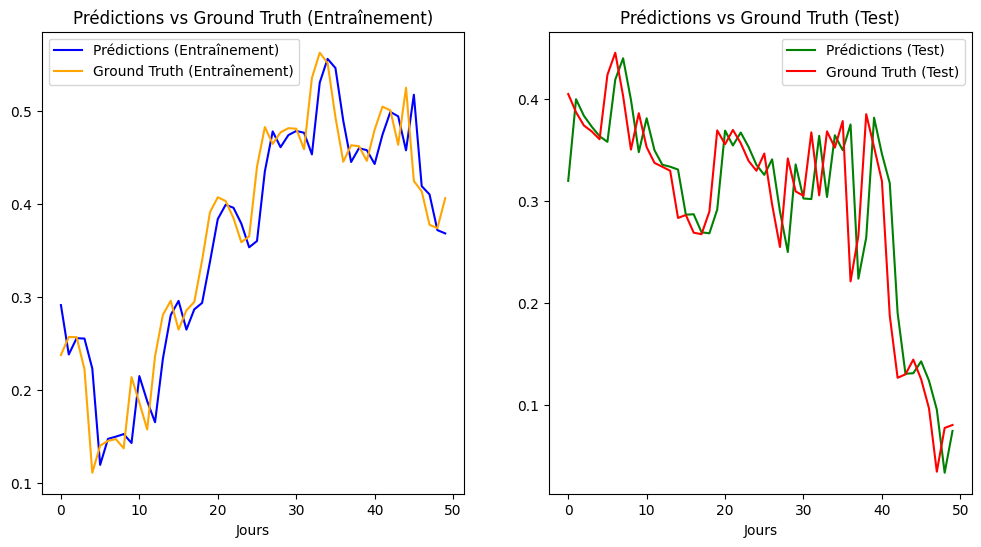

In [135]:

def preparer_donnees_prediction(stock_index, data):
    sequences_x = []
    sequences_y = []
    for i in range(len(data[0]) - longueur_sequence):
        sequence_x = data[stock_index, i:i+longueur_sequence]
        sequence_y = data[stock_index, i+longueur_sequence]
        sequences_x.append(sequence_x)
        sequences_y.append(sequence_y)

    return np.array(sequences_x), np.array(sequences_y)



def predire_stock(model, stock_index, data):
    data_x, data_y = preparer_donnees_prediction(stock_index, data)

    # plot the first stock in the train set

    with torch.no_grad():

        data_x_tensor = torch.tensor(data_x, dtype=torch.float32,device="cpu")
        data_x_tensor = data_x_tensor.unsqueeze(-1)
        print(data_x_tensor.shape)
        model = model.to(torch.device("cpu"))
        predictions = model.predict_next_day(data_x_tensor)
    return predictions.cpu().numpy(), data_y
# Utilisation de la fonction predire_stock pour obtenir les prédictions et les sorties attendues pour un stock spécifique dans l'ensemble d'entraînement
indice_stock_a_predire_train = 4
predictions_stock_train, sorties_attendues_train = predire_stock(model_attention, indice_stock_a_predire_train, donnes_train)
print(donnes_test.shape)
# Utilisation de la fonction predire_stock pour obtenir les prédictions et les sorties attendues pour un stock spécifique dans l'ensemble de test
indice_stock_a_predire_test = 4 # Choisir un indice approprié du jeu de test
predictions_stock_test, sorties_attendues_test = predire_stock(model_attention, indice_stock_a_predire_test,donnes_test)

# Plot des prédictions et des sorties attendues pour les ensembles d'entraînement et de test côte à côte
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # Première colonne du subplot pour les données d'entraînement
plt.plot(predictions_stock_train[:50], label='Prédictions (Entraînement)', color='blue')
plt.plot(sorties_attendues_train[:50], label='Ground Truth (Entraînement)', color='orange')
plt.title('Prédictions vs Ground Truth (Entraînement)')
plt.xlabel('Jours')
plt.legend()

plt.subplot(1, 2, 2)  # Deuxième colonne du subplot pour les données de test
plt.plot(predictions_stock_test[:50], label='Prédictions (Test)', color='green')
plt.plot(sorties_attendues_test[:50], label='Ground Truth (Test)', color='red')
plt.title('Prédictions vs Ground Truth (Test)')
plt.xlabel('Jours')
plt.legend()
plt.show()



In [ ]:
# take random values from

In [ ]:
def KL_loss(mu, sigma):
    return -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())

def reconstruction_loss(x, y):

    return nn.MSELoss(reduction='sum')(x,y)

def loss_function(x, original_x, mu, sigma,k1=1,k2=4e-2):
    reconstruction  = reconstruction_loss(x, original_x)
    kl = KL_loss(mu, sigma)
    return k1 * reconstruction + k2 * kl  , reconstruction, kl


In [ ]:
# Convert the numpy array to a PyTorch tensor
# The shape is : (number_of_stocks, number_of_sub_series, sub_series_length, features)
# We need to reshape it to (number_of_stocks * number_of_sub_series, sub_series_length, features)
number_of_stocks = stocks_np_array.shape[0]
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

stocks_np_array_test = stocks_np_array.reshape((number_of_stocks*number_of_sub_series, sub_series_length, 1))
signal_to_tensor = torch.from_numpy(stocks_np_array_test).float().to(device)
print(f"signal_to_tensor shape : {stocks_np_array_test.shape}")
# Forward pass through the model
#x, original_x, mu, sigma = model_LSTM(signal_to_tensor)

# Reconstruct the good output shape
#x = x.reshape((number_of_stocks, number_of_sub_series, sub_series_length, 1))


In [ ]:
# load from cuda to cpu
#model = torch.load("model.pth",map_location=torch.device('cpu'))

In [ ]:
# Plot the reconstruction
# Plot 10 random stocks
number_of_stocks_to_plot = 5
random_stocks = np.random.randint(0, number_of_stocks, number_of_stocks_to_plot)
print(f"random stocks : {random_stocks}")
# Plot 10 random sub-series
random_sub_series = np.random.randint(0, number_of_sub_series, number_of_stocks_to_plot)
print(f"random sub series : {random_sub_series}")
# Plot the original and reconstructed signals
for i in range(number_of_stocks_to_plot):
    plt.plot(original_x[random_stocks[i]][random_sub_series[i]].cpu().detach().numpy(), label='Original signal')
    plt.plot(x[random_stocks[i]][random_sub_series[i]].cpu().detach().numpy(), label='Reconstructed signal')
plt.legend()
plt.show()



In [ ]:
# try a simple overfitting
optimizer = torch.optim.Adam(model_attention.parameters(), lr=1e-3)
batch_size = 32
shuffle = True  # To shuffle the data
data_loader = DataLoader(stocks_np_array, batch_size=batch_size, shuffle=shuffle)
loss_list_KL_attention = []
loss_list_reconstruction_attention = []
loss_list_attention = []
#loss_fn = nn.L1Loss(reduction='sum')

for epoch in range(200):
    epoch_loss_KL = 0
    epoch_loss_reconstruction = 0
    epoch_loss = 0
    for batch in data_loader:
        # Process each batch
        batch = batch.to(device)
        batch = batch.to(torch.float32)
        batch_size_current = batch.shape[0]
        batch = batch.reshape((batch_size_current*number_of_sub_series, sub_series_length, 1))
        # Your processing logic here
        optimizer.zero_grad()
        x, original_x, mu, sigma = model_attention(batch)
        total_loss,reconstruction_l,KL_l = loss_function(x, original_x, mu, sigma)
        total_loss.backward()
        optimizer.step()
        epoch_loss_KL += KL_l.item()
        epoch_loss_reconstruction += reconstruction_l.item()
        epoch_loss += total_loss.item()
    loss_list_KL_attention.append(epoch_loss_KL)
    loss_list_reconstruction_attention.append(epoch_loss_reconstruction)
    loss_list_attention.append(epoch_loss)
    if epoch % 2 == 0:
        print(f'Epoch: {epoch}, loss: {total_loss.item()}')
# plot the loss, KL and reconstruction in 3 different color on the same plot
# normalize loss between 0 and 1
"""loss_list_attention = np.array(loss_list_attention)
loss_list_attention = (loss_list_attention - np.min(loss_list_attention)) / (np.max(loss_list_attention) - np.min(loss_list_attention))
loss_list_KL_attention = np.array(loss_list_KL_attention)
loss_list_KL_attention = (loss_list_KL_attention - np.min(loss_list_KL_attention)) / (np.max(loss_list_KL_attention) - np.min(loss_list_KL_attention))
loss_list_reconstruction_attention = np.array(loss_list_reconstruction_attention)
loss_list_reconstruction_attention = (loss_list_reconstruction_attention - np.min(loss_list_reconstruction_attention)) / (np.max(loss_list_reconstruction_attention) - np.min(loss_list_reconstruction_attention))
"""
plt.figure(figsize=(20, 5))
plt.plot(loss_list_attention, label='Total loss')
plt.plot(loss_list_KL_attention, label='KL loss')
plt.plot(loss_list_reconstruction_attention, label='Reconstruction loss')
plt.legend()
plt.show()


In [ ]:
# try a simple overfitting
optimizer = torch.optim.Adam(model_LSTM.parameters(), lr=2e-4)
batch_size = 32
shuffle = True  # To shuffle the data
data_loader = DataLoader(stocks_np_array, batch_size=batch_size, shuffle=shuffle)
loss_list_KL_LSTM = []
loss_list_reconstruction_lSTM = []
loss_list_LSTM = []
#loss_fn = nn.L1Loss(reduction='sum')

for epoch in range(500):
    epoch_loss_KL = 0
    epoch_loss_reconstruction = 0
    epoch_loss = 0
    for batch in data_loader:
        # Process each batch
        #print("Batch shape:", batch.shape)  # Adjust this according to your processing needs
        batch = batch.to(device)
        batch = batch.to(torch.float32)
        batch_size_current = batch.shape[0]
        batch = batch.reshape((batch_size_current*number_of_sub_series, sub_series_length, 1))
        # Your processing logic here
        optimizer.zero_grad()
        x, original_x, mu, sigma = model_LSTM(batch)
        total_loss,reconstruction_l,KL_l = loss_function(x, original_x, mu, sigma)
        total_loss.backward()
        optimizer.step()
        epoch_loss_KL += KL_l.item()
        epoch_loss_reconstruction += reconstruction_l.item()
        epoch_loss += total_loss.item()
    loss_list_KL_LSTM.append(epoch_loss_KL)
    loss_list_reconstruction_lSTM.append(epoch_loss_reconstruction)
    loss_list_LSTM.append(epoch_loss)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, loss: {total_loss.item()}')
# plot the loss, KL and reconstruction in 3 different color on the same plot
# normalize loss between 0 and 1
"""loss_list_LSTM = np.array(loss_list_LSTM)
loss_list_LSTM = (loss_list_LSTM - np.min(loss_list_LSTM)) / (np.max(loss_list_LSTM) - np.min(loss_list_LSTM))
loss_list_KL_LSTM = np.array(loss_list_KL_LSTM)
loss_list_KL_LSTM = (loss_list_KL_LSTM - np.min(loss_list_KL_LSTM)) / (np.max(loss_list_KL_LSTM) - np.min(loss_list_KL_LSTM))
loss_list_reconstruction_LSTM = np.array(loss_list_reconstruction_lSTM)
loss_list_reconstruction_LSTM = (loss_list_reconstruction_LSTM - np.min(loss_list_reconstruction_LSTM)) / (np.max(loss_list_reconstruction_LSTM) - np.min(loss_list_reconstruction_LSTM))"""
plt.figure(figsize=(20, 5))
plt.plot(loss_list_LSTM, label='Total loss')
plt.plot(loss_list_KL_LSTM, label='KL loss')
plt.plot(loss_list_reconstruction_lSTM, label='Reconstruction loss')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
"""loss_list_LSTM = np.array(loss_list_LSTM)
loss_list_LSTM = (loss_list_LSTM - np.min(loss_list_LSTM)) / (np.max(loss_list_LSTM) - np.min(loss_list_LSTM))
loss_list_KL_LSTM = np.array(loss_list_KL_LSTM)
loss_list_KL_LSTM = (loss_list_KL_LSTM - np.min(loss_list_KL_LSTM)) / (np.max(loss_list_KL_LSTM) - np.min(loss_list_KL_LSTM))
loss_list_reconstruction_LSTM = np.array(loss_list_reconstruction_lSTM)
loss_list_reconstruction_LSTM = (loss_list_reconstruction_LSTM - np.min(loss_list_reconstruction_LSTM)) / (np.max(loss_list_reconstruction_LSTM) - np.min(loss_list_reconstruction_LSTM))
"""# Assuming you have lists of losses: loss_list_KL_LSTM, loss_list_KL_attention,
# loss_list_reconstruction_lSTM, loss_list_reconstruction_attention, loss_list_LSTM, loss_list_attention

# Plotting on three separate subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 5))

# Subplot 1: KL loss
axs[0].plot(loss_list_KL_LSTM, label='KL loss LSTM')
axs[0].plot(loss_list_KL_attention, label='KL loss Attention')
axs[0].set_title('KL Loss')
axs[0].legend()

# Subplot 2: Reconstruction loss
axs[1].plot(loss_list_reconstruction_lSTM, label='Reconstruction loss LSTM')
axs[1].plot(loss_list_reconstruction_attention, label='Reconstruction loss Attention')
axs[1].set_title('Reconstruction Loss')
axs[1].legend()
# Subplot 3: Total loss
axs[2].plot(loss_list_LSTM, label='Total loss LSTM')
axs[2].plot(loss_list_attention, label='Total loss Attention')
axs[2].set_title('Total Loss')
axs[2].legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

with torch.no_grad():
    x, original_x, mu, sigma = model_attention(signal_to_tensor)
    x = x.cpu().detach().numpy()
print(f"x shape : {x.shape}")
# Plot the reconstruction of all signals
stocks_kept= [stock[1] for stock in kept_stocks_with_indexes]
stocks_to_plot = 10
# Reshape the data
print(f"number_of_stocks : {number_of_stocks}")
print(f"number_of_sub_series : {number_of_sub_series}")
print(f"sub_series_length : {sub_series_length}")
stocks_np_array_reshaped = stocks_np_array.reshape((number_of_stocks, number_of_sub_series, sub_series_length))
reconstructed_signals_reshaped = x.reshape((number_of_stocks, number_of_sub_series, sub_series_length, 1))
print(f"stocks_np_array_reshaped shape : {stocks_np_array_reshaped.shape}")
# Plot each stock in separate subplots
plt.figure(figsize=(25, 18))

for i in range(stocks_to_plot):
    plt.subplot(stocks_to_plot, 1, i + 1)
    plt.plot(stocks_np_array_reshaped[i].reshape((-1, 1)), label='Original Signal')
    plt.plot(reconstructed_signals_reshaped[i].reshape((-1, 1)), label='Reconstructed Signal')
    plt.title(f'Stock {stocks_kept[i]} - Original vs Reconstructed Signals')
    plt.xlabel('Time Step')
    plt.ylabel('Normalized Value')
    plt.legend()


plt.show()


In [ ]:
# Apply PCA to the latent space

from sklearn.decomposition import PCA
# Set seeds for reproducibility


with torch.no_grad():
    # with lstm : add _
    signals_latent,_,_,_= model_attention.encoder(signal_to_tensor)
    signals_latent = signals_latent.squeeze().cpu().detach().numpy()
print(f"signals_latent shape : {signals_latent.shape}")
pca = PCA(n_components=2)
latent_space = pca.fit_transform(signals_latent)
# Reshape the latent space for each stock

latent_space_np_array = np.array(latent_space).reshape((number_of_stocks, number_of_sub_series, 2))
print(f"latent_space_np_array shape : {latent_space_np_array.shape}")
# Plot the latent space for each stock
plt.figure(figsize=(12, 8))

for i, latent_space_stock in enumerate(latent_space_np_array):
    plt.scatter(latent_space_stock[:, 0], latent_space_stock[:, 1], label=f'{stock_symbols[i]}')

    # Annotate each point with its index
    for j in range(number_of_sub_series):
        plt.annotate(str(j), (latent_space_stock[j, 0], latent_space_stock[j, 1]))

plt.legend()
plt.title('Latent Space Visualization with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [ ]:
# Apply PCA to the latent space

from sklearn.decomposition import PCA
# Set seeds for reproducibility

print(signal_to_tensor.shape)
with torch.no_grad():
    signals_latent,_,_,_ = model_attention.encoder(signal_to_tensor)
    signals_latent = signals_latent.squeeze().cpu().detach().numpy()
    print(signals_latent.shape)
signals_latent_sumed = signals_latent.reshape(number_of_stocks,number_of_sub_series,latent_dim )

signals_latent_sumed = np.sum(signals_latent_sumed, axis=(1))

print(f"signals_latent shape : {signals_latent_sumed.shape}")
pca = PCA(n_components=2)
latent_space = pca.fit_transform(signals_latent_sumed)
# Reshape the latent space for each stock
print(latent_space.shape)
latent_space_np_array = np.array(latent_space).reshape((number_of_stocks, 2))
print(f"latent_space_np_array shape : {latent_space_np_array.shape}")
# Plot the latent space for each stock
plt.figure(figsize=(12, 8))

for i, latent_space_stock in enumerate(latent_space_np_array):
    plt.scatter(latent_space_stock[0], latent_space_stock[1], label=f'{stock_symbols[i]}')

    # Annotate each point with its index
    for j in range(number_of_sub_series):
        plt.annotate(str(j), (latent_space_stock[0], latent_space_stock[1]))

plt.legend()
plt.title('Latent Space Visualization with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [ ]:
# Apply K-means to the latent space
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Set seeds for reproducibility
seed = 42
K_means_PCA = KMeans(n_clusters=8, random_state=seed)
K_means_PCA.fit(latent_space_np_array)
inertia_Kmeans_PCA = K_means_PCA.inertia_
plt.figure(figsize=(12, 8))
plt.scatter(latent_space_np_array[:, 0], latent_space_np_array[:, 1], c=K_means_PCA.labels_, cmap='rainbow')
plt.scatter(K_means_PCA.cluster_centers_[:, 0], K_means_PCA.cluster_centers_[:, 1], color='black')
plt.title('K-means Clustering with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()



In [ ]:
 # Elbow Method for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model_bis = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model_bis, k=(2,30), timings= True)
# Fit data to visualizer
visualizer.fit(latent_space_np_array)
visualizer.show()        # Finalize and render figure

In [ ]:
# Silhouette Score for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
models = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(models, k=(2,30),metric='silhouette', timings= True)
visualizer.fit(latent_space_np_array)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [ ]:
cluster_to_plot = 0
# Plot the signals in the cluster
plt.figure(figsize=(20, 5))
for i, cluster in enumerate(K_means_PCA.labels_):
    if cluster == cluster_to_plot:
        plt.plot(stocks_np_array_reshaped[i].reshape((-1, 1)), label=f'{stock_symbols[i]}')
plt.title(f'Stocks in Cluster {cluster_to_plot}')
plt.xlabel('Time Step')
plt.ylabel('Normalized Value')
plt.legend()
plt.show()

In [ ]:
# interpolate between two signales
# take the first signal
print(f"latent_signal_np_array shape : {signals_latent.shape}")
signals_latent = signals_latent.reshape((number_of_stocks, number_of_sub_series, latent_dim))

signal_1_index,signal_1_name = 79, stock_symbols[79]

signal_2_index ,signal_2_name = 43, stock_symbols[43]
signal_1 = signals_latent[signal_1_index]
signal_2 = signals_latent[signal_2_index]

# define the number of points to interpolate
number_of_points = signal_1.shape[0]
print(f"number_of_points : {number_of_points}")
print(f"signal_1 shape : {signal_1.shape}")
print(f"signal_2 shape : {signal_2.shape}")
new_signal = np.zeros((number_of_points,latent_dim))

for i in range(number_of_points):


    new_signal[i] = (signal_1[i] + (signal_2[i]) ) / 2

# apply PCA to the new signal
#pca = PCA(n_components=2)
#
# plot the latent space with the 3 signals in different colors
#latent_space_new_signal = pca.fit_transform(new_signal)
latent_space_new_signal = new_signal
plt.scatter(signal_1[:,0],signal_1[:,1],label=signal_1_name)
plt.scatter(signal_2[:,0],signal_2[:,1],label=signal_2_name)
plt.scatter(latent_space_new_signal[:,0],latent_space_new_signal[:,1],label='new signal')
for i in range(number_of_points):
    plt.annotate(str(i), (signal_1[i, 0], signal_1[i, 1]))
    plt.annotate(str(i), (signal_2[i, 0], signal_2[i, 1]))
    plt.annotate(str(i), (latent_space_new_signal[i, 0], latent_space_new_signal[i, 1]))
plt.legend()
plt.show()

In [ ]:
# decode the new signal
new_signal = torch.from_numpy(new_signal).float().to(device)
new_signal = new_signal.squeeze()
print(f"new signal shape : {new_signal.shape}")
with torch.no_grad():
    new_signal_decoded = model_LSTM.decoder(new_signal)
    new_signal_decoded = nn.Tanh()(new_signal_decoded)
    new_signal_decoded = new_signal_decoded.squeeze().cpu().detach().numpy()
print(f"new signal decoded shape : {new_signal_decoded.shape}")
new_signal_decoded = new_signal_decoded.reshape((number_of_sub_series*sub_series_length,1))

stocks_array_flatten = stocks_np_array.reshape((number_of_stocks,number_of_sub_series*sub_series_length,1))
print(f"stocks_array_flatten shape : {stocks_array_flatten.shape}")
# plot the new signal decoded, the first signal and the second signal
plt.figure(figsize=(20, 15))
plt.plot(stocks_array_flatten[signal_1_index],label=signal_1_name)
plt.plot(stocks_array_flatten[signal_2_index],label=signal_2_name)
plt.plot(new_signal_decoded,label='new signal decoded')
plt.legend()
plt.show()


In [ ]:
import numpy as np

# Supposons que signals_latent, number_of_stocks, number_of_sub_series, latent_dim, signal_symbols sont définis

# Réorganiser signals_latent
signals_latent = signals_latent.reshape((number_of_stocks, number_of_sub_series, latent_dim))

signal_1_index, signal_1_name = 79, stock_symbols[79]
signal_2_index, signal_2_name = 43, stock_symbols[43]

signal_1 = signals_latent[signal_1_index]
signal_2 = signals_latent[signal_2_index]

# Définir le nombre de points à interpoler
number_of_points = 10

# Créer un tableau de points entre signal_1 et signal_2
interpolated_signals = np.linspace(signal_1, signal_2, num=number_of_points+2)[1:-1]  # Générer les points intermédiaires
# Afficher les formes des signaux
print(f"Forme de signal_1 : {signal_1.shape}")
print(f"Forme de signal_2 : {signal_2.shape}")
print(f"Forme des signaux interpolés : {interpolated_signals.shape}")

# Le tableau interpolated_signals contient les 10 valeurs intermédiaires entre signal_1 et signal_2


In [ ]:
# decode the new signal
interpolated_signals_tensor = torch.from_numpy(interpolated_signals).float().to(device)
interpolated_signals_tensor = interpolated_signals_tensor.squeeze()
interpolated_signals_tensor = interpolated_signals_tensor.reshape((number_of_points*number_of_sub_series,latent_dim))


In [ ]:
with torch.no_grad():
    interpolated_signals_decoded = model_LSTM.decoder(interpolated_signals_tensor)
    interpolated_signals_decoded = nn.Tanh()(interpolated_signals_decoded)
    interpolated_signals_decoded = interpolated_signals_decoded.squeeze().cpu().detach().numpy()
print(f"interpolated_signals_decoded shape : {interpolated_signals_decoded.shape}")
interpolated_signals_decoded = interpolated_signals_decoded.reshape((number_of_points,number_of_sub_series*sub_series_length,1))
print(f"interpolated_signals_decoded shape : {interpolated_signals_decoded.shape}")

In [ ]:
# plot the new signal decoded, the first signal and the second signal
plt.figure(figsize=(20, 15))
plt.plot(stocks_array_flatten[signal_1_index],label=signal_1_name)
plt.plot(stocks_array_flatten[signal_2_index],label=signal_2_name)
for i in range(number_of_points):
    plt.plot(interpolated_signals_decoded[i],label=f"interpolated signal {i}")
plt.legend()
plt.show()